# Characterization of ALPACA's modules

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Preparation
First we read the membership file from ALPACA, the two networks, and we prepare the data

In [165]:
# Output directory
import os
outputDir = "../results/alpaca-batch-coad-subtype-connnectivity-20250317/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
# ALPACA membership file
membership_fn = "../data/processed/alpaca-batch-coad-subtype-20240510/membership_csm2_csm4.csv"
# Read membership
membership = pd.read_csv(membership_fn)
membership.head()


node  module  modularity
0   ALX1_A       1    0.006097
1   ALX3_A       2    0.011064
2   ALX4_A       1    0.005248
3     AR_A       2    0.001445
4  ARGFX_A       2    0.012254

In [166]:
# clean membership table splitting node into node_name and node_type
membership['node_name'] = membership.node.str.split('_').str[0]
membership['node_type'] = membership.node.str.split('_').str[1]
membership.head()


node  module  modularity node_name node_type
0   ALX1_A       1    0.006097      ALX1         A
1   ALX3_A       2    0.011064      ALX3         A
2   ALX4_A       1    0.005248      ALX4         A
3     AR_A       2    0.001445        AR         A
4  ARGFX_A       2    0.012254     ARGFX         A

In [167]:
# map the genes with gencode
gencode = '/Users/violafanfani/Documents/uni-harvard/projects/tcga-data-supplement/data/external/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode, sep=',')
ens2symbol = gencode.set_index('gene_id')['gene_name'].to_dict()
ens2symbol = {k.split('.')[0]: v for k, v in ens2symbol.items()}
membership['gene_symbol'] = [ens2symbol[i] if i.startswith('ENSG') else i for i in membership['node_name']]
membership

node  module  modularity        node_name node_type  \
0                 ALX1_A       1    0.006097             ALX1         A   
1                 ALX3_A       2    0.011064             ALX3         A   
2                 ALX4_A       1    0.005248             ALX4         A   
3                   AR_A       2    0.001445               AR         A   
4                ARGFX_A       2    0.012254            ARGFX         A   
...                  ...     ...         ...              ...       ...   
20641  ENSG00000253451_B       8    0.000065  ENSG00000253451         B   
20642  ENSG00000278020_B       8    0.000120  ENSG00000278020         B   
20643  ENSG00000148926_B       1    0.000090  ENSG00000148926         B   
20644  ENSG00000146477_B       4    0.000040  ENSG00000146477         B   
20645  ENSG00000273329_B       8   -0.000012  ENSG00000273329         B   

         gene_symbol  
0               ALX1  
1               ALX3  
2               ALX4  
3                 AR  
4              ARGFX  
...              ...  
20641       IGLV2-28  
20642   HOXA11-AS1_6  
20643            ADM  
20644        SLC22A3  
20645  RP11-448A19.1  

[20646 rows x 6 columns]

## Analysis of PANDA connectivity

Here, using the modules identified by ALPACA, we check the differences in connectivity between the two subtypes

In [168]:
# read the two networks
cms2_net = pd.read_csv("../data/processed/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt", sep=" ", index_col=0)
cms4_net = pd.read_csv("../data/processed/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt", sep=" ", index_col=0)

In [169]:
# read the two networks
cms2_net = pd.read_csv("../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt", sep=" ", index_col=0)
cms4_net = pd.read_csv("../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt", sep=" ", index_col=0)

### Prepare an edge membership table

In [58]:
# melt the dataframe and keep the index
cms2_long = cms2_net.melt(ignore_index = False, var_name = 'gene', value_name='cms2').reset_index()
cms4_long = cms4_net.melt(ignore_index = False, var_name = 'gene', value_name='cms4').reset_index()

In [59]:
# Get the two nets
nets = cms2_long.merge(cms4_long, on =['tf','gene'], how = 'inner')
nets.shape

(19590053, 4)

In [60]:
nets.head()

tf             gene      cms2      cms4
0   ALX1  ENSG00000000003  1.639950  0.701865
1   ALX3  ENSG00000000003  0.463252  0.087116
2   ALX4  ENSG00000000003  1.347992  0.552226
3     AR  ENSG00000000003 -0.986745 -0.862890
4  ARGFX  ENSG00000000003  0.887296  0.290060

In [61]:
# In this table we report each edge (tf-gene) , the CMS2 and CMS4 values and the membership of the gene and the tf
edge_membership = nets.merge(membership, left_on='gene', right_on='node_name', how = 'left')
edge_membership = edge_membership.merge(membership, left_on='tf', right_on='node_name', how = 'left', suffixes=('_gene', '_tf'))
edge_membership.head()

tf             gene      cms2      cms4          node_gene  module_gene  \
0   ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B            7   
1   ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B            7   
2   ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B            7   
3     AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B            7   
4  ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B            7   

   modularity_gene   node_name_gene node_type_gene gene_symbol_gene  node_tf  \
0         0.002225  ENSG00000000003              B           TSPAN6   ALX1_A   
1         0.002225  ENSG00000000003              B           TSPAN6   ALX3_A   
2         0.002225  ENSG00000000003              B           TSPAN6   ALX4_A   
3         0.002225  ENSG00000000003              B           TSPAN6     AR_A   
4         0.002225  ENSG00000000003              B           TSPAN6  ARGFX_A   

   module_tf  modularity_tf node_name_tf node_type_tf gene_symbol_tf  
0          1       0.006097         ALX1            A           ALX1  
1          2       0.011064         ALX3            A           ALX3  
2          1       0.005248         ALX4            A           ALX4  
3          2       0.001445           AR            A             AR  
4          2       0.012254        ARGFX            A          ARGFX

In [62]:
# For each edge, check if TF-gene are in the same module
edge_membership['same_module'] = edge_membership.module_gene == edge_membership.module_tf
edge_membership['edge_module'] = edge_membership['same_module'].astype(int) * edge_membership['module_gene'].astype(int)
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene    node_tf  module_tf  modularity_tf node_name_tf  \
0                  TSPAN6     ALX1_A          1       0.006097         ALX1   
1                  TSPAN6     ALX3_A          2       0.011064         ALX3   
2                  TSPAN6     ALX4_A          1       0.005248         ALX4   
3                  TSPAN6       AR_A          2       0.001445           AR   
4                  TSPAN6    ARGFX_A          2       0.012254        ARGFX   
...                   ...        ...        ...            ...          ...   
19590048          MIR7847   ZSCAN4_A          2       0.002642       ZSCAN4   
19590049          MIR7847   ZSCAN5_A          4       0.002277       ZSCAN5   
19590050          MIR7847  ZSCAN5C_A          4       0.000994      ZSCAN5C   
19590051          MIR7847   ZSCAN9_A          1       0.002776       ZSCAN9   
19590052          MIR7847     ZZZ3_A          1       0.001415         ZZZ3   

         node_type_tf gene_symbol_tf  same_module  edge_module  
0                   A           ALX1        False            0  
1                   A           ALX3        False            0  
2                   A           ALX4        False            0  
3                   A             AR        False            0  
4                   A          ARGFX        False            0  
...               ...            ...          ...          ...  
19590048            A         ZSCAN4         True            2  
19590049            A         ZSCAN5        False            0  
19590050            A        ZSCAN5C        False            0  
19590051            A         ZSCAN9        False            0  
19590052            A           ZZZ3        False            0  

[19590053 rows x 18 columns]

In [63]:
# Compute the edge difference and absolute edge difference
edge_membership['diff_edge'] = edge_membership['cms2'] - edge_membership['cms4']
edge_membership['diff_edge_abs'] = abs(edge_membership['diff_edge'])
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene    node_tf  module_tf  modularity_tf node_name_tf  \
0                  TSPAN6     ALX1_A          1       0.006097         ALX1   
1                  TSPAN6     ALX3_A          2       0.011064         ALX3   
2                  TSPAN6     ALX4_A          1       0.005248         ALX4   
3                  TSPAN6       AR_A          2       0.001445           AR   
4                  TSPAN6    ARGFX_A          2       0.012254        ARGFX   
...                   ...        ...        ...            ...          ...   
19590048          MIR7847   ZSCAN4_A          2       0.002642       ZSCAN4   
19590049          MIR7847   ZSCAN5_A          4       0.002277       ZSCAN5   
19590050          MIR7847  ZSCAN5C_A          4       0.000994      ZSCAN5C   
19590051          MIR7847   ZSCAN9_A          1       0.002776       ZSCAN9   
19590052          MIR7847     ZZZ3_A          1       0.001415         ZZZ3   

         node_type_tf gene_symbol_tf  same_module  edge_module  diff_edge  \
0                   A           ALX1        False            0   0.938085   
1                   A           ALX3        False            0   0.376136   
2                   A           ALX4        False            0   0.795765   
3                   A             AR        False            0  -0.123855   
4                   A          ARGFX        False            0   0.597237   
...               ...            ...          ...          ...        ...   
19590048            A         ZSCAN4         True            2  -0.186063   
19590049            A         ZSCAN5        False            0   0.043963   
19590050            A        ZSCAN5C        False            0   0.030223   
19590051            A         ZSCAN9        False            0   0.056616   
19590052            A           ZZZ3        False            0   0.055825   

          diff_edge_abs  
0              0.938085  
1              0.376136  
2              0.795765  
3              0.123855  
4              0.597237  
...                 ...  
19590048       0.186063  
19590049       0.043963  
19590050       0.030223  
19590051       0.056616  
19590052       0.055825  

[19590053 rows

In [64]:
# We add an indicator to count the edges
edge_membership['is_edge'] = 1
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene  ... module_tf  modularity_tf  node_name_tf  \
0                  TSPAN6  ...         1       0.006097          ALX1   
1                  TSPAN6  ...         2       0.011064          ALX3   
2                  TSPAN6  ...         1       0.005248          ALX4   
3                  TSPAN6  ...         2       0.001445            AR   
4                  TSPAN6  ...         2       0.012254         ARGFX   
...                   ...  ...       ...            ...           ...   
19590048          MIR7847  ...         2       0.002642        ZSCAN4   
19590049          MIR7847  ...         4       0.002277        ZSCAN5   
19590050          MIR7847  ...         4       0.000994       ZSCAN5C   
19590051          MIR7847  ...         1       0.002776        ZSCAN9   
19590052          MIR7847  ...         1       0.001415          ZZZ3   

         node_type_tf gene_symbol_tf same_module  edge_module  diff_edge  \
0                   A           ALX1       False            0   0.938085   
1                   A           ALX3       False            0   0.376136   
2                   A           ALX4       False            0   0.795765   
3                   A             AR       False            0  -0.123855   
4                   A          ARGFX       False            0   0.597237   
...               ...            ...         ...          ...        ...   
19590048            A         ZSCAN4        True            2  -0.186063   
19590049            A         ZSCAN5       False            0   0.043963   
19590050            A        ZSCAN5C       False            0   0.030223   
19590051            A         ZSCAN9       False            0   0.056616   
19590052            A           ZZZ3       False            0   0.055825   

          diff_edge_abs  is_edge  
0              0.938085        1  
1              0.376136        1  
2              0.795765        1  
3              0.123855        1  
4              0.597237        1  
...                 ...      ...  
19590048       0.186063        1  
19590049       0.043963        1  
19590050       0.030223        1  
19590051       0.056616        1  
19590052       0.055825   

In [65]:
# We compute the IN- and OUT-module degrees
same_module_degrees = (edge_membership[edge_membership['same_module'] == True]).loc[:,['gene','module_gene','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['gene','module_gene']).sum().reset_index()
same_module_degrees['same_module'] = True
diff_module_degrees = (edge_membership[edge_membership['same_module'] == False]).loc[:,['gene','module_gene','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['gene','module_gene']).sum().reset_index()
diff_module_degrees['same_module'] = False
module_degrees = pd.concat([same_module_degrees, diff_module_degrees], axis=0)
module_degrees.sort_values('gene')

gene  module_gene     cms2     cms4  diff_edge  \
0      ENSG00000000003            7       15       19       -3.5   
0      ENSG00000000003            7     -9.6      -99         90   
1      ENSG00000000005            2 -1.8e+02 -1.9e+02        7.3   
1      ENSG00000000005            2       20     -8.1         28   
2      ENSG00000000419            2    2e+02    2e+02         -4   
...                ...          ...      ...      ...        ...   
19618  ENSG00000284564            1    1e+02    2e+02        -94   
19619  ENSG00000284570            1  3.3e+02  3.8e+02        -50   
19647  ENSG00000284570            1 -4.1e+02 -4.9e+02         76   
19620  ENSG00000284594            2 -1.3e+02 -1.3e+02          5   
19648  ENSG00000284594            2 -1.5e+02 -1.7e+02         14   

       diff_edge_abs  is_edge  same_module  
0                5.9       20         True  
0            3.5e+02      977        False  
1                 83      754        False  
1                 29      243         True  
2                 13      243         True  
...              ...      ...          ...  
19618             95      251         True  
19619             51      251         True  
19647        1.5e+02      746        False  
19620             15      243         True  
19648             44      754        False  

[39270 rows x 8 columns]

FWER threshold: , 0.0016129032258064516
Module 1,stat:385813.0, p: 0.0
Module 2,stat:2143764.0, p: 1.8729015239018414e-32
Module 3,stat:36981.0, p: 0.005900874893958021
Module 4,stat:1433866.0, p: 0.0
Module 5,stat:98890.0, p: 0.0002123507912633931
Module 6,stat:104579.0, p: 2.2754201289414773e-19
Module 7,stat:32643.0, p: 3.154133866856099e-05
Module 8,stat:2663962.0, p: 8.132157319803211e-07
Module 9,stat:218707.0, p: 7.614819402960453e-07
Module 10,stat:955.0, p: 0.008536097523712965
Module 11,stat:869.0, p: 1.5909601385626815e-09
Module 12,stat:98998.0, p: 0.3369269658896168
Module 13,stat:9620.0, p: 0.0619823983567691
Module 14,stat:62.0, p: 0.1956329345703125


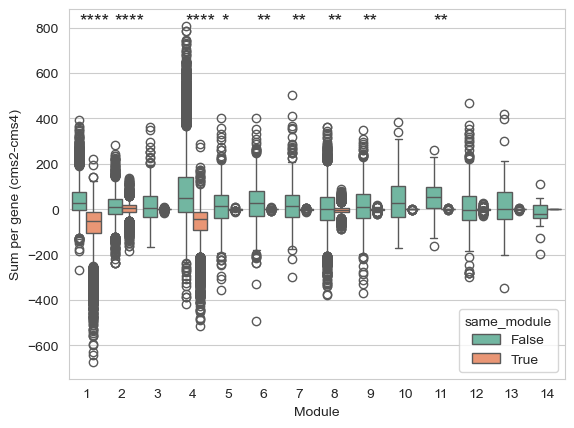

In [68]:
def return_significance(p):
    if p<1e-30:
        return '****'
    elif p<1e-3:
        return '**'
    elif p<1e-2:
        return '*'
    else:
        return('')

# seaborn set color to whitegrid
sns.set_style('whitegrid')

sigs = []
n_bonferroni = len(module_degrees['module_gene'].unique())
print(f'FWER threshold: , {0.05/n_bonferroni}')
df_wilk_genes = pd.DataFrame()
for module, tab in module_degrees[module_degrees['module_gene']<15].groupby('module_gene'):
    stat, p = stats.wilcoxon(tab[tab['same_module']==True]['diff_edge'], tab[tab['same_module']==False]['diff_edge'])
    a = return_significance(p*n_bonferroni)
    sigs.append(a)
    print(f'Module {module},stat:{stat}, p: {p}')
    df_wilk_genes = pd.concat([df_wilk_genes, pd.DataFrame({'module': module, 'stat': stat, 'p': p, 'Bonferroni FWER': np.min([1., p*n_bonferroni]),
                                                        "mean IN-module degree": np.mean(tab[tab['same_module']==True]['diff_edge']),
                                                        "mean OUT-module degree": np.mean(tab[tab['same_module']==False]['diff_edge'])}, index=[0])], axis=0)

sns.boxplot(x='module_gene', y='diff_edge', data=module_degrees[module_degrees['module_gene']<15], hue = 'same_module', palette = 'Set2')
# annotate significance
for i, txt in enumerate(sigs):
    plt.annotate(txt, (i-0.2, np.max(module_degrees[module_degrees['module_gene']<15]['diff_edge'])), fontsize=14)
plt.xlabel('Module')
plt.ylabel('Sum per gene (cms2-cms4)')
plt.show()

In [38]:
df_wilk_genes.module = df_wilk_genes.module.astype('str')

In [69]:
pd.options.display.float_format = None
pd.set_option('display.float_format', '{:.2g}'.format)
print(df_wilk_genes.to_latex(index=False,
                  formatters={"name": str.upper,"stat": "{:.2f}".format, "p": "{:.2E}".format, "Bonferroni FWER": "{:.2E}".format},
))

\begin{tabular}{rrrrrr}
\toprule
module & stat & p & Bonferroni FWER & mean IN-module degree & mean OUT-module degree \\
\midrule
1 & 385813.00 & 0.00E+00 & 0.00E+00 & -78.194178 & 43.655882 \\
2 & 2143764.00 & 1.87E-32 & 5.81E-31 & 2.421301 & 10.373974 \\
3 & 36981.00 & 5.90E-03 & 1.83E-01 & -0.132168 & 13.994770 \\
4 & 1433866.00 & 0.00E+00 & 0.00E+00 & -63.115197 & 89.458204 \\
5 & 98890.00 & 2.12E-04 & 6.58E-03 & 0.165063 & 12.623169 \\
6 & 104579.00 & 2.28E-19 & 7.05E-18 & 0.347839 & 28.194577 \\
7 & 32643.00 & 3.15E-05 & 9.78E-04 & -0.414056 & 21.782637 \\
8 & 2663962.00 & 8.13E-07 & 2.52E-05 & -4.844230 & 2.151773 \\
9 & 218707.00 & 7.61E-07 & 2.36E-05 & -1.094298 & 14.393717 \\
10 & 955.00 & 8.54E-03 & 2.65E-01 & 0.074718 & 39.860753 \\
11 & 869.00 & 1.59E-09 & 4.93E-08 & 0.659262 & 53.029421 \\
12 & 98998.00 & 3.37E-01 & 1.00E+00 & -0.456192 & 9.702970 \\
13 & 9620.00 & 6.20E-02 & 1.00E+00 & -0.154742 & 14.593134 \\
14 & 62.00 & 1.96E-01 & 1.00E+00 & 0.024142 & -20.562472 \\
\

### Now we do the same for TFs (compute degrees and differential degrees)

In [53]:
same_module_degrees = (edge_membership[edge_membership['same_module'] == True]).loc[:,['tf','module_tf','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['tf','module_tf']).sum().reset_index()
same_module_degrees['same_module'] = True
diff_module_degrees = (edge_membership[edge_membership['same_module'] == False]).loc[:,['tf','module_tf','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['tf','module_tf']).sum().reset_index()
diff_module_degrees['same_module'] = False
tf_degrees = pd.concat([same_module_degrees, diff_module_degrees], axis=0)
tf_degrees.sort_values('tf')

tf_degrees['differential_degree'] = tf_degrees['cms2'] - tf_degrees['cms4']


In [54]:
tf_degrees

tf  module_tf     cms2     cms4  diff_edge  diff_edge_abs  is_edge  \
0       ALX1          1  5.6e+03  7.5e+03   -1.8e+03          2e+03     3601   
1       ALX3          2  3.9e+03  3.9e+03        -45        5.4e+02     3351   
2       ALX4          1  4.7e+03  6.4e+03   -1.6e+03        1.8e+03     3601   
3         AR          2 -1.5e+03 -1.6e+03         82        3.3e+02     3351   
4      ARGFX          2  6.1e+03  6.2e+03        -89        8.7e+02     3351   
..       ...        ...      ...      ...        ...            ...      ...   
992   ZSCAN4          2 -2.2e+03 -2.4e+03      2e+02        4.7e+03    16298   
993   ZSCAN5          4 -3.5e+03 -4.7e+03    1.2e+03        3.1e+03    14829   
994  ZSCAN5C          4      -81  1.8e+02   -2.6e+02        2.4e+03    14829   
995   ZSCAN9          1  1.9e+02 -1.2e+03    1.4e+03        5.4e+03    16048   
996     ZZZ3          1 -2.3e+03 -3.1e+03    8.3e+02        3.2e+03    16048   

     same_module  differential_degree  
0           True             -1.8e+03  
1           True                  -45  
2           True             -1.6e+03  
3           True                   82  
4           True                  -89  
..           ...                  ...  
992        False                2e+02  
993        False              1.2e+03  
994        False             -2.6e+02  
995        False              1.4e+03  
996        False              8.3e+02  

[1994 rows x 9 columns]

In [58]:
tab[tab['same_module']==True]

tf  module_tf  cms2  cms4  diff_edge  diff_edge_abs  is_edge  \
817  ZNF385D         14    87    87       0.46            2.3       19   

     same_module  differential_degree  
817         True                 0.46

FWER threshold: , 0.0035714285714285718
Module 1,stat:40.0, p: 1.0248886991655897e-42
Module 2,stat:7088.0, p: 1.7654741798452378e-12
Module 3,stat:11.0, p: 0.0008392333984375
Module 4,stat:788.0, p: 9.046025939011586e-42
Module 5,stat:207.0, p: 0.83135736733675
Module 6,stat:2.0, p: 1.3969838619232178e-09
Module 7,stat:83.0, p: 0.4304332733154297
Module 8,stat:254.0, p: 1.909507566350996e-06
Module 9,stat:136.0, p: 0.00011535796875250526
Module 10,stat:3.0, p: 1.0
Module 11,stat:0.0, p: 0.03125
Module 12,stat:28.0, p: 0.0006937980651855469
Module 13,stat:0.0, p: 0.015625
Module 14,stat:0.0, p: 1.0


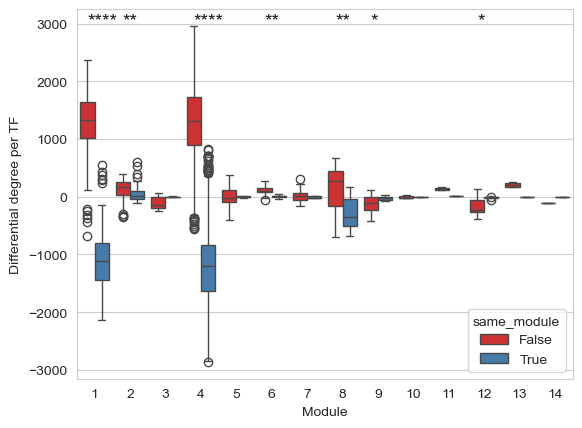

In [61]:
sigs = []
n_bonferroni = len(tf_degrees['module_tf'].unique())
print(f'FWER threshold: , {0.05/n_bonferroni}')
df_wilk_tfs = pd.DataFrame()

for module, tab in tf_degrees[tf_degrees['module_tf']<15].groupby('module_tf'):
    

    stat, p = stats.wilcoxon(tab[tab['same_module']==True]['differential_degree'], tab[tab['same_module']==False]['differential_degree'])
    a = return_significance(p*n_bonferroni)
    sigs.append(a)
    print(f'Module {module},stat:{stat}, p: {p}')
    
    df_wilk_tfs = pd.concat([df_wilk_tfs, pd.DataFrame({'module': module, 
                                                        'stat': stat, 
                                                        'p': p, 
                                                        'Bonferroni FWER': np.min([1., p*n_bonferroni]),
                                                        "mean IN-module degree": np.mean(tab[tab['same_module']==True]['differential_degree']),
                                                        "mean OUT-module degree": np.mean(tab[tab['same_module']==False]['differential_degree'])                                                       
                                                        }, index=[0])], axis=0)


sns.boxplot(x='module_tf', y='differential_degree', data=tf_degrees[tf_degrees['module_tf']<15], hue = 'same_module', palette = 'Set1')
# annotate significance
for i, txt in enumerate(sigs):
    plt.annotate(txt, (i-0.2, np.max(tf_degrees[tf_degrees['module_tf']<15]['differential_degree'])), fontsize=14)
plt.xlabel('Module')
plt.ylabel('Differential degree per TF')
plt.show()

In [62]:
pd.options.display.float_format = None
pd.set_option('display.float_format', '{:.2g}'.format)
print(df_wilk_tfs.to_latex(index=False,
                  formatters={"name": str.upper,"stat": "{:.2f}".format, "p": "{:.2E}".format, "Bonferroni FWER": "{:.2E}".format},
))

\begin{tabular}{rrrrrr}
\toprule
module & stat & p & Bonferroni FWER & mean IN-module degree & mean OUT-module degree \\
\midrule
1 & 40.00 & 1.02E-42 & 1.43E-41 & -1121.821654 & 1331.685448 \\
2 & 7088.00 & 1.77E-12 & 2.47E-11 & 33.390045 & 133.276001 \\
3 & 11.00 & 8.39E-04 & 1.17E-02 & -3.249790 & -110.794156 \\
4 & 788.00 & 9.05E-42 & 1.27E-40 & -1139.382961 & 1268.302363 \\
5 & 207.00 & 8.31E-01 & 1.00E+00 & 3.910279 & -2.354879 \\
6 & 2.00 & 1.40E-09 & 1.96E-08 & 8.815545 & 115.128064 \\
7 & 83.00 & 4.30E-01 & 1.00E+00 & -8.550258 & 13.984968 \\
8 & 254.00 & 1.91E-06 & 2.67E-05 & -282.032701 & 170.765688 \\
9 & 136.00 & 1.15E-04 & 1.62E-03 & -28.205519 & -121.859152 \\
10 & 3.00 & 1.00E+00 & 1.00E+00 & 1.892866 & -2.441624 \\
11 & 0.00 & 3.12E-02 & 4.38E-01 & 11.427210 & 139.448435 \\
12 & 28.00 & 6.94E-04 & 9.71E-03 & -13.333253 & -158.706423 \\
13 & 0.00 & 1.56E-02 & 2.19E-01 & -4.686480 & 206.724260 \\
14 & 0.00 & 1.00E+00 & 1.00E+00 & 0.458702 & -102.928285 \\
\bottomrule
\en

### Check the leading TF by modularity

In [170]:
membership_tf = membership[membership['node_type']=='A']
map_n_tf = membership_tf.loc[:,['module','node_name']].groupby('module').count().rename(columns={'node_name':'n_tf'})
membership_tf = membership_tf.merge(map_n_tf, left_on='module', right_index=True)
membership_tf['raw_modularity'] = membership_tf['modularity'] * membership_tf['n_tf']
membership_tf

node  module  modularity node_name node_type gene_symbol  n_tf  \
0       ALX1_A       1    0.006097      ALX1         A        ALX1   251   
1       ALX3_A       2    0.011064      ALX3         A        ALX3   243   
2       ALX4_A       1    0.005248      ALX4         A        ALX4   251   
3         AR_A       2    0.001445        AR         A          AR   243   
4      ARGFX_A       2    0.012254     ARGFX         A       ARGFX   243   
..         ...     ...         ...       ...       ...         ...   ...   
992   ZSCAN4_A       2    0.002642    ZSCAN4         A      ZSCAN4   243   
993   ZSCAN5_A       4    0.002277    ZSCAN5         A      ZSCAN5   267   
994  ZSCAN5C_A       4    0.000994   ZSCAN5C         A     ZSCAN5C   267   
995   ZSCAN9_A       1    0.002776    ZSCAN9         A      ZSCAN9   251   
996     ZZZ3_A       1    0.001415      ZZZ3         A        ZZZ3   251   

     raw_modularity  
0          1.530413  
1          2.688537  
2          1.317150  
3          0.351055  
4          2.977676  
..              ...  
992        0.642077  
993        0.607919  
994        0.265437  
995        0.696806  
996        0.355115  

[997 rows x 8 columns]

In [171]:
membership_gene = membership[membership['node_type']=='B']

In [172]:
# Cluster of interest 1,2 4,6,8
membership_tf[membership_tf['module'].isin([1,2,4,6,8])].sort_values(['raw_modularity'], ascending=[False])

node  module  modularity node_name node_type gene_symbol  n_tf  \
742  ZNF180_A       4    0.013892    ZNF180         A      ZNF180   267   
867  ZNF529_A       4    0.013748    ZNF529         A      ZNF529   267   
336    LHX9_A       2    0.014763      LHX9         A        LHX9   243   
335    LHX8_A       2    0.014594      LHX8         A        LHX8   243   
325    LBX1_A       2    0.014521      LBX1         A        LBX1   243   
..        ...     ...         ...       ...       ...         ...   ...   
675   ZBTB3_A       8    0.001050     ZBTB3         A       ZBTB3    59   
89     E2F2_A       6    0.001759      E2F2         A        E2F2    32   
842  ZNF449_A       8    0.000935    ZNF449         A      ZNF449    59   
398    NFE2_A       8    0.000595      NFE2         A        NFE2    59   
205   GMEB1_A       2    0.000016     GMEB1         A       GMEB1   243   

     raw_modularity  
742        3.709086  
867        3.670711  
336        3.587384  
335        3.546335  
325        3.528676  
..              ...  
675        0.061969  
89         0.056279  
842        0.055189  
398        0.035090  
205        0.003915  

[852 rows x 8 columns]

In [321]:
top_tfs = pd.DataFrame()
for k, tab in membership_tf.groupby('module'):
    print(k)
    # select the first 100 edges based on the first 10 tf modularities and the first 10 gene modularities
    print(tab.sort_values('modularity', ascending=False)['node_name'].values[:10].tolist())
    top_tfs = pd.concat([top_tfs, tab.sort_values('modularity', ascending=False).head(10)], axis=0)

1
['ZNF334', 'FOXD2', 'HMG20B', 'ZNF33B', 'FOXD3', 'POU3F3', 'VSX2', 'ARID5B', 'NR1H4', 'ZNF25']
2
['LHX9', 'LHX8', 'LBX1', 'PBX4', 'DLX6', 'LHX2', 'SHOX2', 'PRRX1', 'PRRX2', 'SHOX']
3
['ARNT', 'ARNT2', 'BHLHE41', 'ARNTL', 'TFE3', 'BHLHE40', 'MLXIPL', 'MLX', 'SREBF2', 'USF1']
4
['ZNF180', 'ZNF529', 'ZNF341', 'ZNF444', 'ZNF467', 'PRDM9', 'ZNF468', 'ZNF304', 'ZNF383', 'ZNF880']
5
['FOSB', 'FOSL2', 'CREB5', 'ATF3', 'CREM', 'ATF2', 'CREB3L4', 'CREB1', 'FOSL1', 'ATF7']
6
['OLIG3', 'OLIG1', 'ATOH7', 'BHLHE23', 'NEUROD2', 'NEUROG1', 'NEUROG2', 'BHLHE22', 'PPARD', 'RXRA']
7
['HEY1', 'HEY2', 'HEYL', 'HES2', 'HES5', 'HES1', 'HES7', 'MYCN', 'HOXD1', 'HOXC8']
8
['ZNF225', 'ZNF487', 'ZNF235', 'ZNF287', 'ZNF443', 'PRDM6', 'ZNF182', 'ZNF496', 'ZNF181', 'ZNF98']
9
['ELK4', 'ELK3', 'ETV4', 'ETV1', 'ETV3', 'ERF', 'GABPA', 'FLI1', 'FEV', 'ELK1']
10
['GLI3', 'GLI1', 'GLI2']
11
['HOXC9', 'HOXB9', 'HOXA11', 'HOXA10', 'HOXD11', 'KDM2B']
12
['KLF6', 'KLF12', 'KLF14', 'KLF2', 'SP3', 'KLF4', 'KLF3', 'SP9', 'KLF

/Users/violafanfani/miniconda3/envs/m1-ml-py10/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


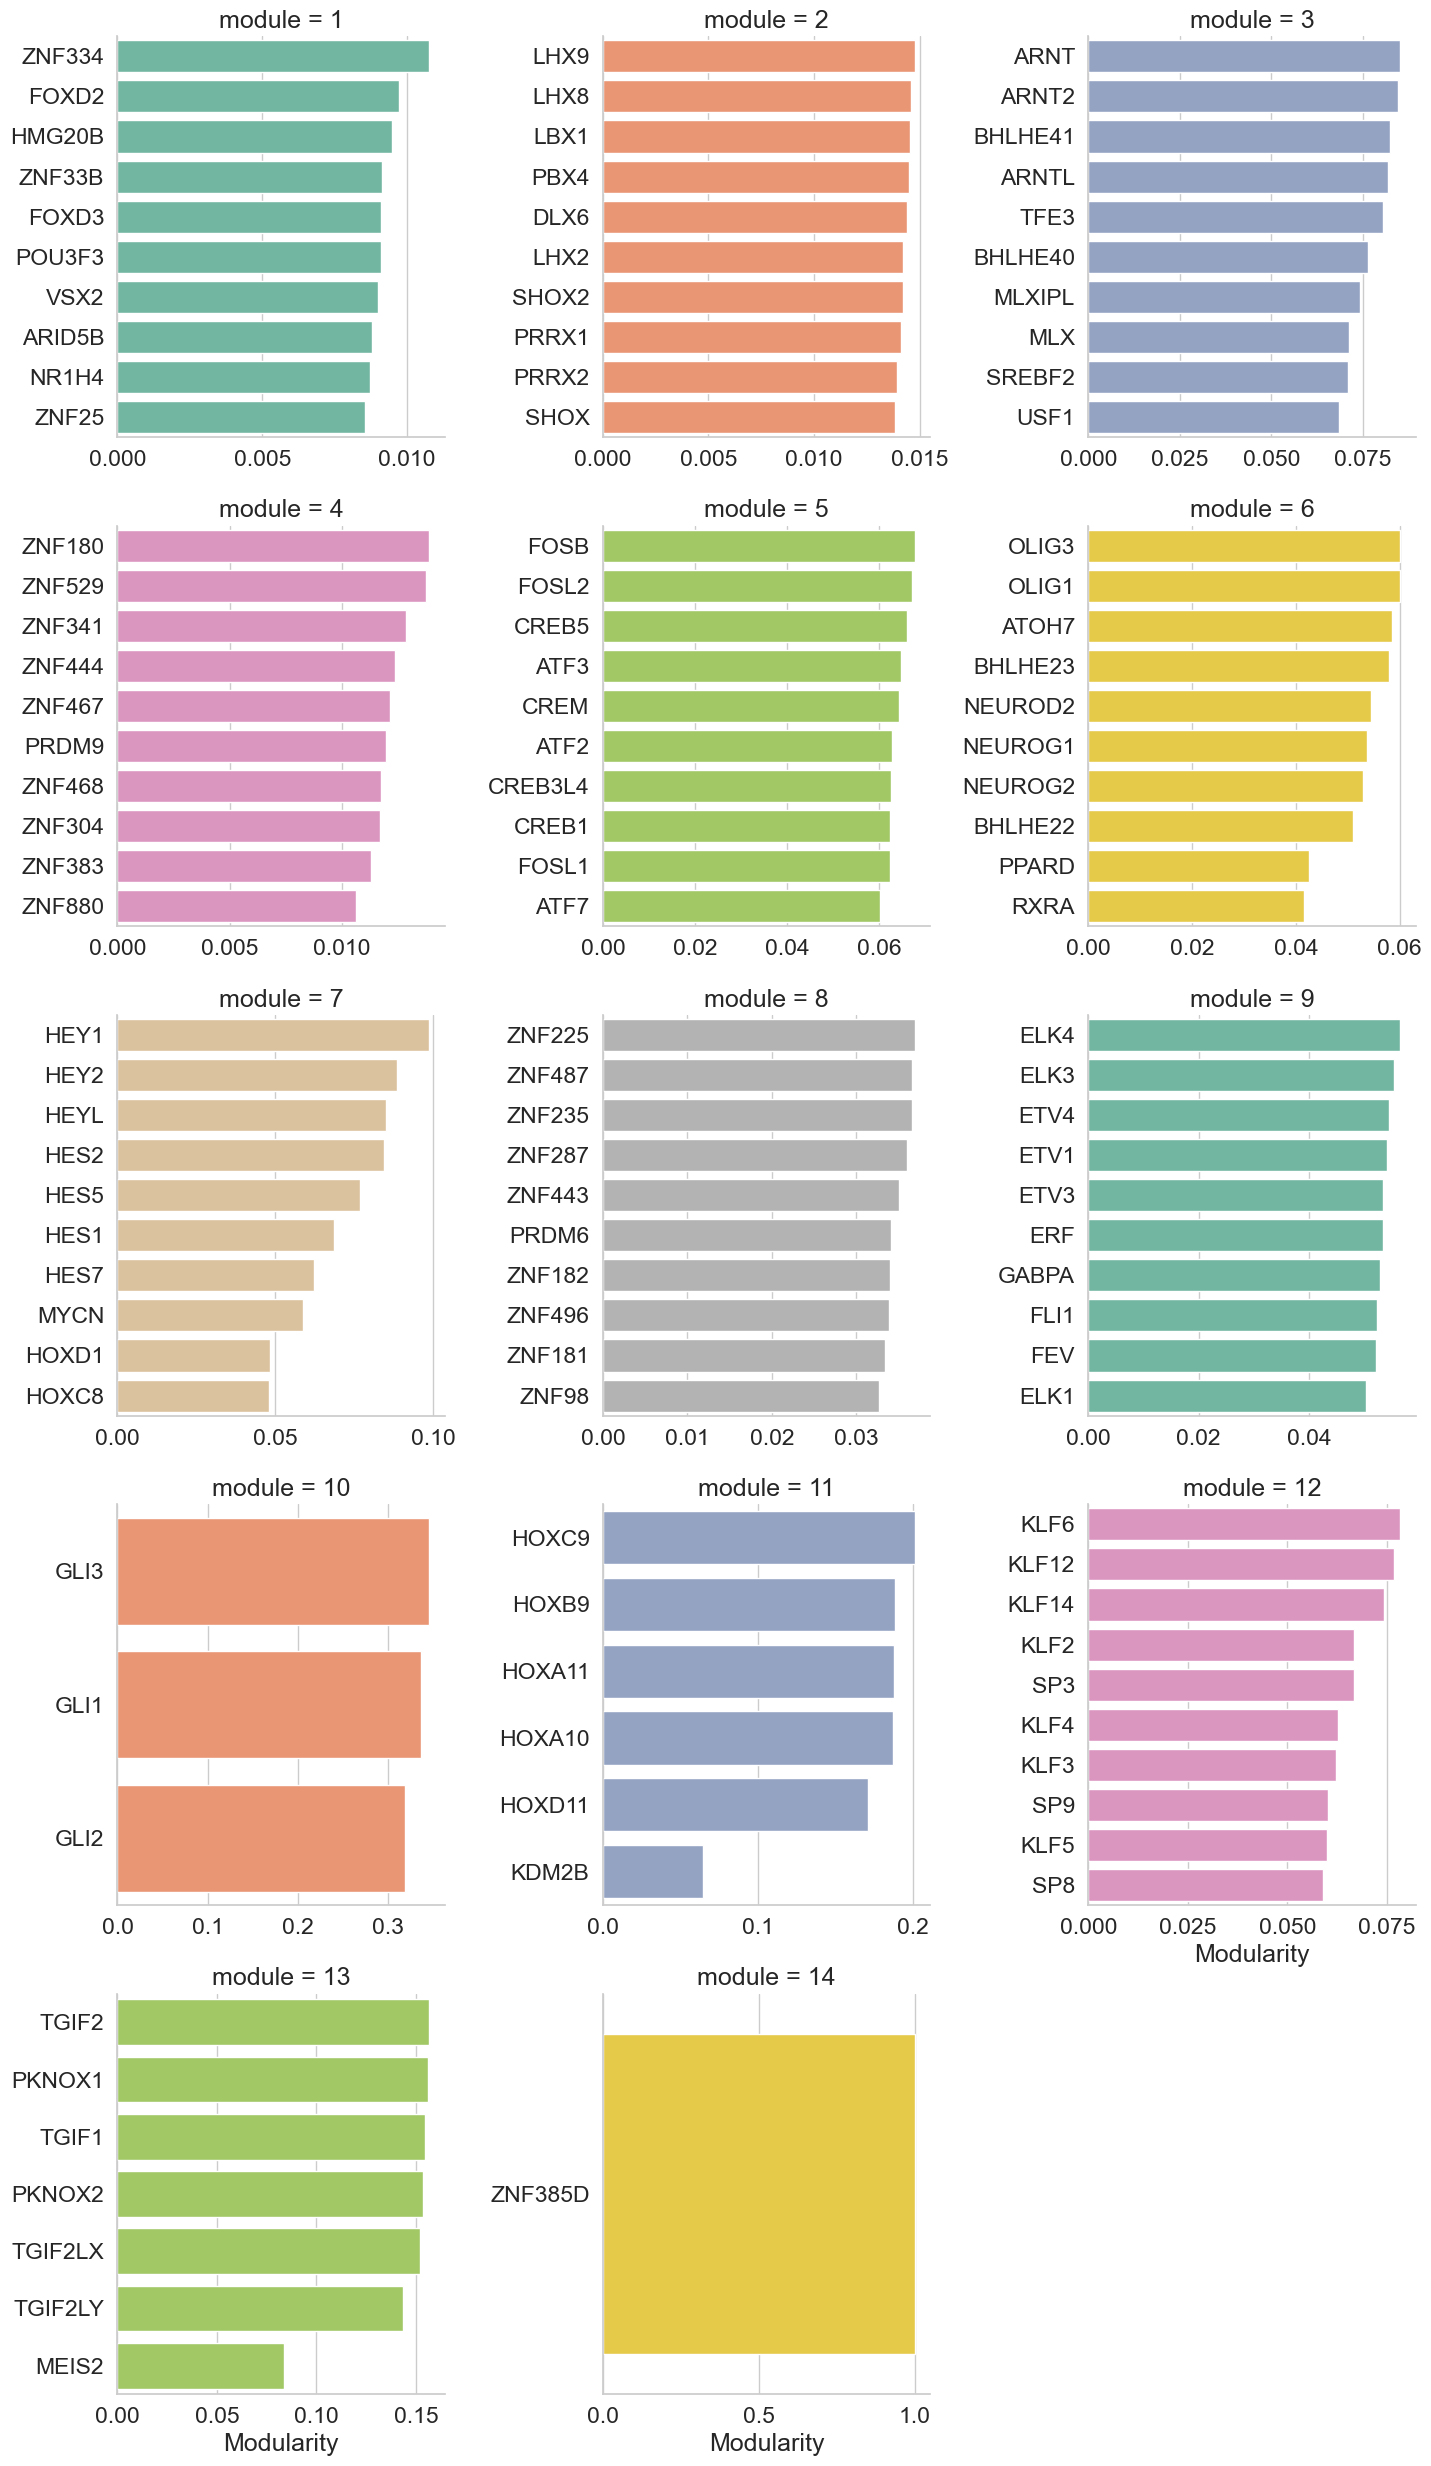

In [98]:
sns.set_context("notebook", font_scale=1.5)
g1 = sns.catplot(col='module', x='modularity', data=top_tfs, y='node_name', palette = 'Set2', hue = 'module', ax = ax, col_wrap=3, height=5, sharey=False, kind = 'bar', legend = False, sharex=False)
g1.set_xlabels('Modularity')
g1.set_ylabels('')
g1.fig.savefig(outputDir + 'top_tfs_modules_all.pdf', dpi=300)

/Users/violafanfani/miniconda3/envs/m1-ml-py10/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


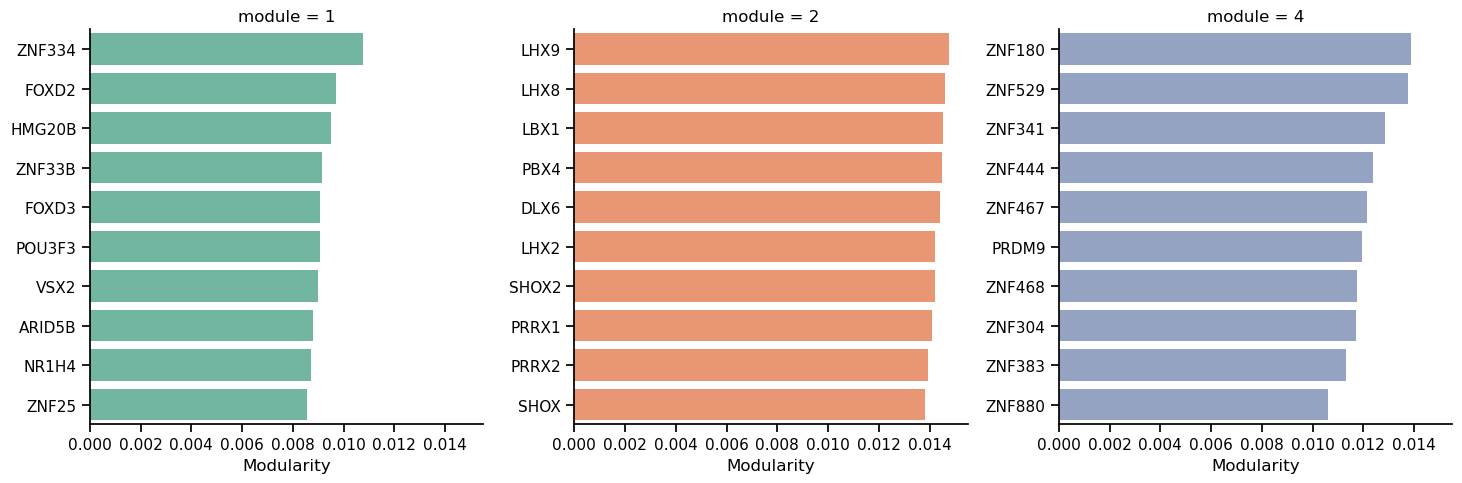

In [322]:
sns.set_context("notebook")
g1 = sns.catplot(col='module', x='modularity', data=top_tfs[top_tfs['module'].isin([1,2,4])], y='node_name', palette = 'Set2', hue = 'module', ax = ax, col_wrap=3, height=5, sharey=False, kind = 'bar', legend = False)
g1.set_xlabels('Modularity')
g1.set_ylabels('')
g1.fig.savefig(outputDir + 'top_tfs_modules_1_2_4.pdf', dpi=300)

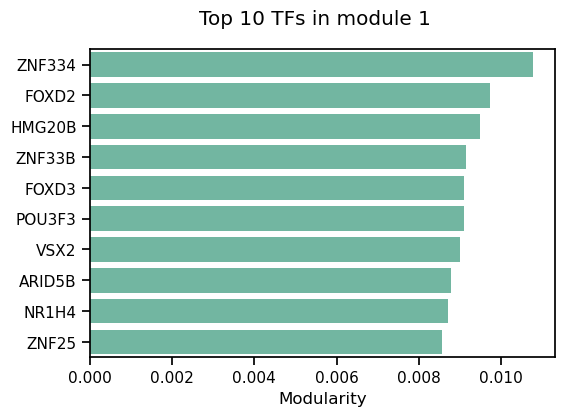

In [331]:
sns.set_context("notebook")
f, ax = plt.subplots(figsize=(6,4))
sns.barplot(x='modularity', data=top_tfs[top_tfs['module'].isin([1])], y='node_name', palette = 'Set2', hue = 'module',legend = False,ax = ax)
ax.set_xlabel('Modularity')
ax.set_ylabel('')
f.suptitle('Top 10 TFs in module 1')
f.savefig(outputDir + 'top_tfs_modules_1.pdf', dpi=300)

# I want the top ones (both gene and TF for module 1)


In [5]:
m1 = membership[membership['module']==1]
m11 = membership[membership['module']==11]

In [6]:
def plot_top_modularity(membership, module_number, top_n=20):
    sns.set_context("notebook")
    df_m = membership[membership['module']==module_number].sort_values('modularity', ascending=False)
    
    f,ax = plt.subplots(1,2,figsize=(8,6))
    sns.barplot(x='modularity', y='gene_symbol', data=df_m[df_m['node_type']=='A'].head(top_n), palette = 'Set2', ax = ax[0])
    sns.barplot(x='modularity', y='gene_symbol', data=df_m[df_m['node_type']=='B'].head(top_n), palette = 'Set2', ax = ax[1])
    
    ax[0].set_title(f'Top {top_n} genes in module {module_number}')
    ax[0].set_xlabel('Modularity')
    ax[0].set_ylabel('')
    
    ax[1].set_title(f'Top {top_n} genes in module {module_number}')
    ax[1].set_xlabel('Modularity')
    ax[1].set_ylabel('')
    plt.tight_layout()
    plt.show()
    return ax

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/1586449296.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='modularity', y='gene_symbol', data=df_m[df_m['node_type']=='A'].head(top_n), palette = 'Set2', ax = ax[0])
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/1586449296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='modularity', y='gene_symbol', data=df_m[df_m['node_type']=='B'].head(top_n), palette = 'Set2', ax = ax[1])


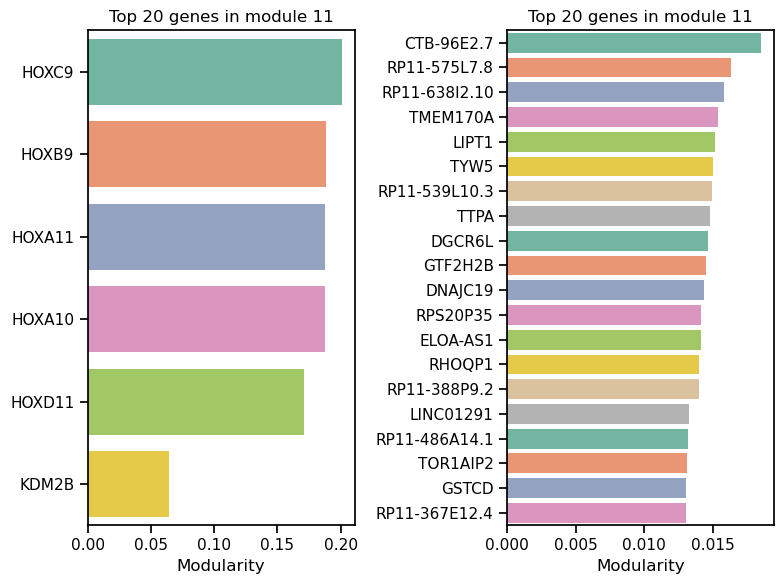

array([<Axes: title={'center': 'Top 20 genes in module 11'}, xlabel='Modularity'>,
       <Axes: title={'center': 'Top 20 genes in module 11'}, xlabel='Modularity'>],
      dtype=object)

In [173]:
plot_top_modularity(membership, 11)

In [10]:
kegg_alpaca = pd.read_csv("/Users/violafanfani/Documents/uni-harvard/projects/tcga-data-supplement/results/alpaca-batch-coad-subtype-connnectivity-20250317/cms2_cms4_pathway_kegg.tsv", sep ='\t')
kegg_alpaca.head()

category                    subcategory  \
0                        Human Diseases                 Immune disease   
1  Environmental Information Processing            Signal transduction   
2                        Human Diseases  Infectious disease: parasitic   
3                        Human Diseases         Cardiovascular disease   
4                        Human Diseases  Infectious disease: bacterial   

         ID                Description GeneRatio   BgRatio        pvalue  \
0  hsa05323       Rheumatoid arthritis   42/1104   95/9436  1.259931e-15   
1  hsa04668      TNF signaling pathway   39/1104  119/9436  8.127574e-10   
2  hsa05140              Leishmaniasis   28/1104   79/9436  2.926480e-08   
3  hsa05417  Lipid and atherosclerosis   53/1104  216/9436  8.240937e-08   
4  hsa05152               Tuberculosis   46/1104  182/9436  2.353889e-07   

       p.adjust        qvalue  \
0  4.308963e-13  3.262558e-13   
1  1.389815e-07  1.052307e-07   
2  3.336187e-06  2.526014e-06   
3  7.046001e-06  5.334922e-06   
4  1.610060e-05  1.219067e-05   

                                              geneID  Count  module  
0  3683/51606/10673/6347/942/523/3552/6372/3553/1...     42       1  
1  843/8837/6401/330/355/6416/1906/1540/5594/9252...     39       1  
2  3459/3717/5594/3552/3676/3553/7099/7097/2212/5...     28       1  
3  6401/355/6416/387/4775/3717/5594/7494/57534/35...     53       1  
4  843/3920/3459/51606/387/7879/30835/3717/5594/8...     46       1

In [644]:
def plot_pathways_kegg_module(data, module, th = 0.01, output_file=None):
    data = data[data['p.adjust'] < th]
    kas_1 = data[data['module']==module].sort_values(['category','Count'], ascending=[True, False])
    kas_1['-log10(p.adjust)'] = -np.log10(kas_1['p.adjust'])
    # 
    f, ax = plt.subplots(figsize=(4, len(kas_1)*0.22))
    sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' , 
                    data=kas_1, palette = sns.color_palette("tab20", 20), ax = ax, size = '-log10(p.adjust)', sizes=(20, 300))
    # draw row lines for each category with name on the side, you need to check how long each category is 
    maxx = kas_1['Count'].max()
    for i in range(0,len(kas_1)):
        if i == 0:
            ax.text(maxx+2, i-0.5, kas_1.iloc[i]['category'], fontsize=9, va='center', ha='right')
        else: 
            if kas_1.iloc[i]['category'] != kas_1.iloc[i-1]['category']:
                if kas_1.iloc[i]['category']=='Environmental Information Processing':
                    short = 'Env. Info. Processing'
                else:
                    short = kas_1.iloc[i]['category']
                ax.text(maxx+2, i + len(kas_1[kas_1['category'] == kas_1.iloc[i]['category']])/2-0.5, short, fontsize=9, va='center', ha='right')
                ax.axhline(i-0.5, color='black', linestyle='--')
    
    f.suptitle(f'KEGG pathways in module {module}', fontsize=14)
    # Legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    if output_file:
        f.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f'Saved figure to {output_file}')



Plotting KEGG pathways for module 1


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


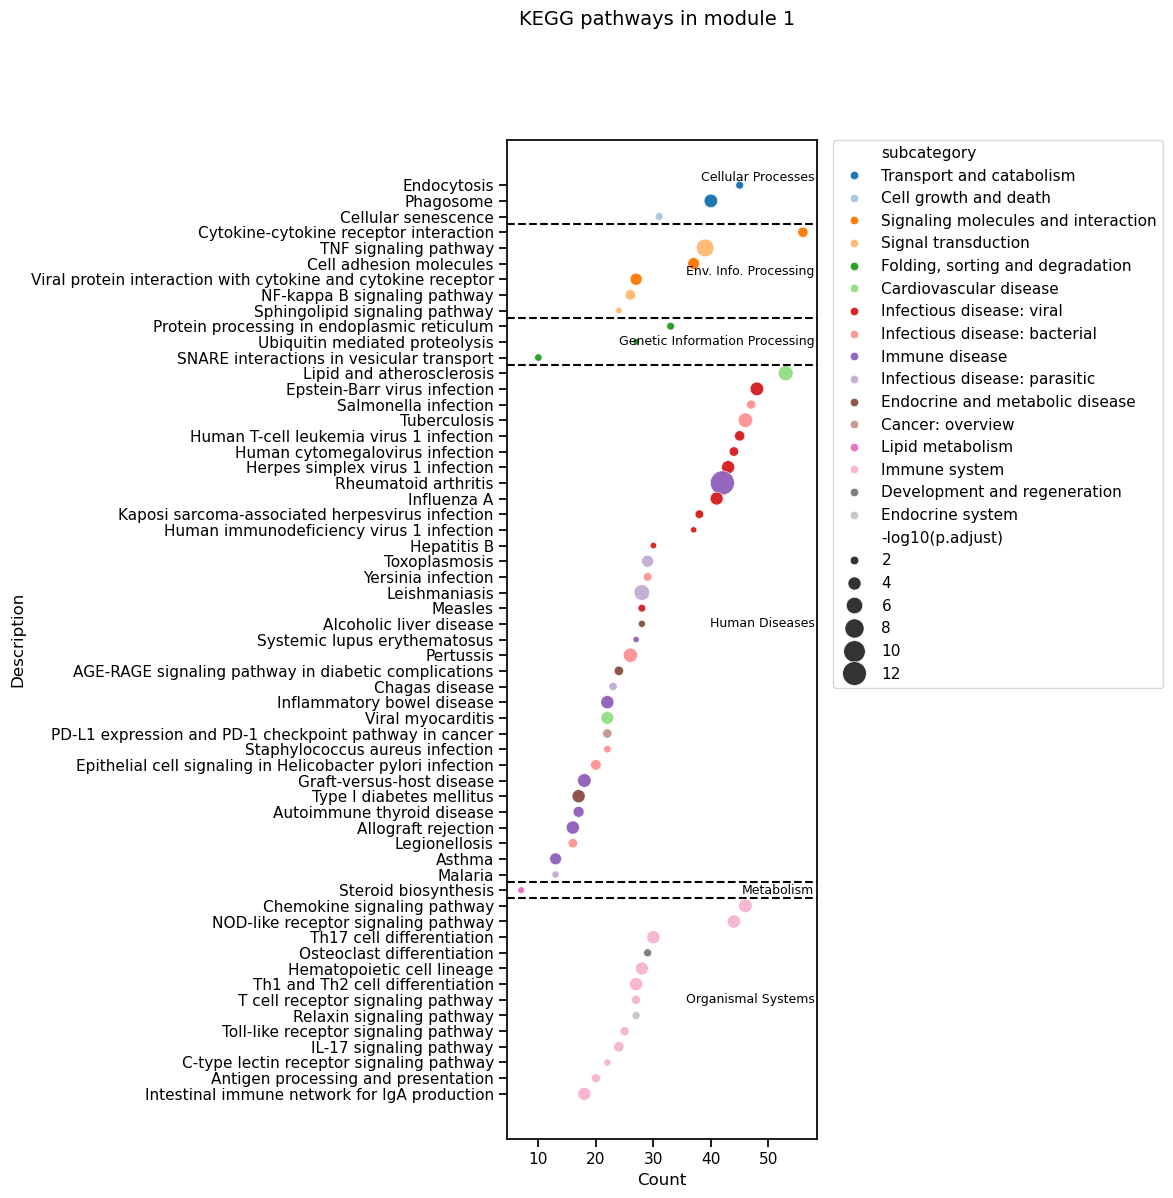

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_1.pdf
Plotting KEGG pathways for module 2


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: 
The palette list has fewer values (20) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


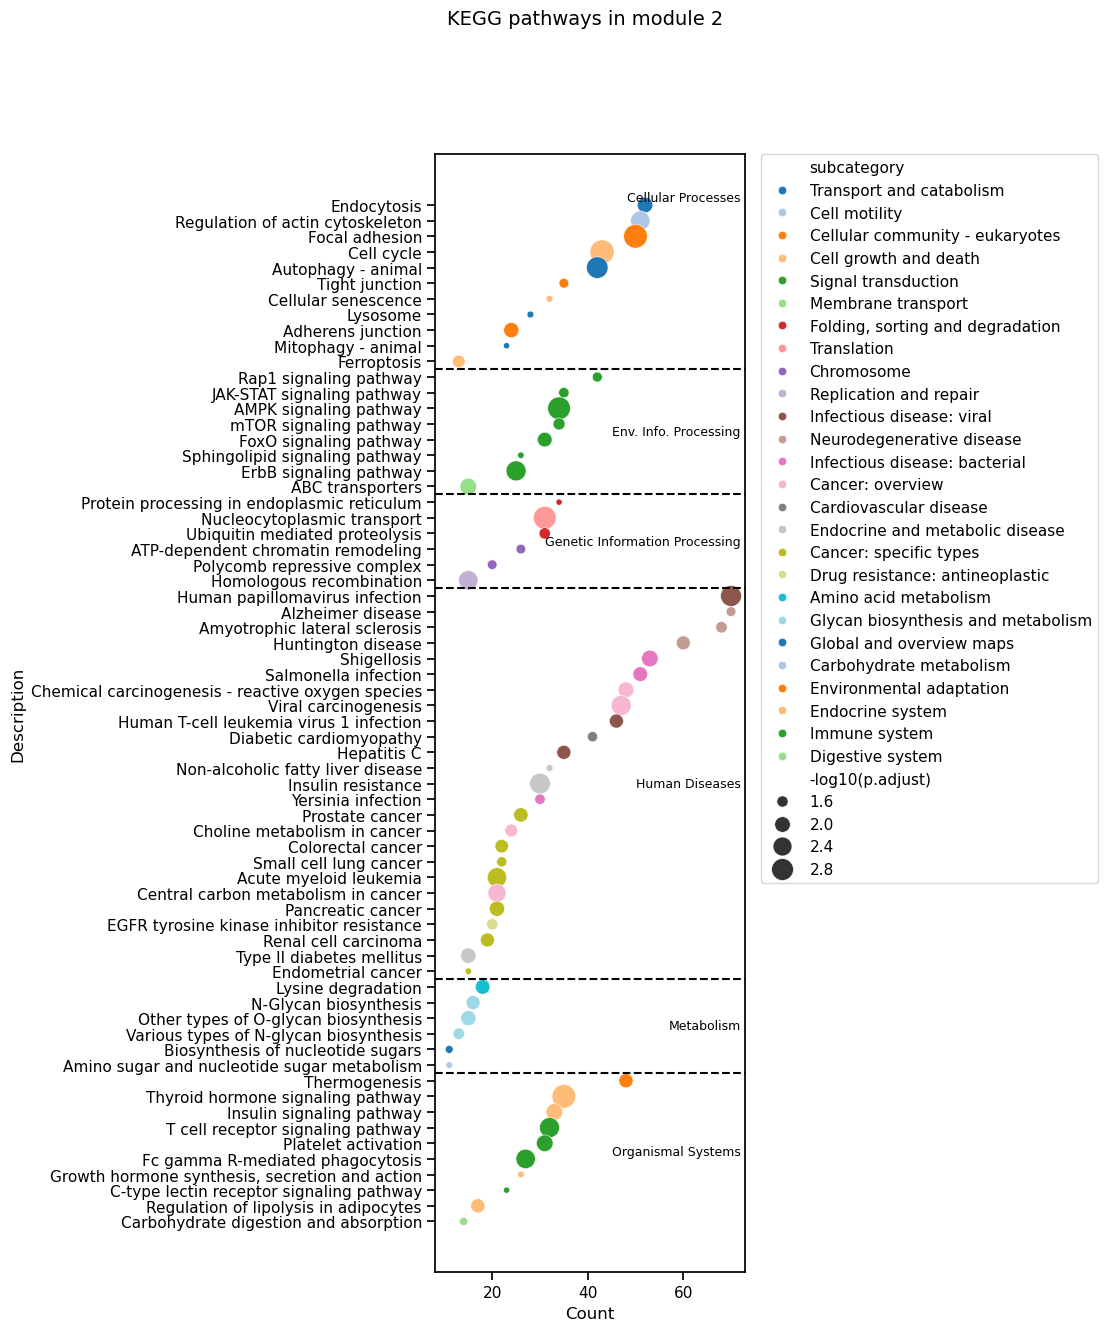

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_2.pdf
Plotting KEGG pathways for module 3


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


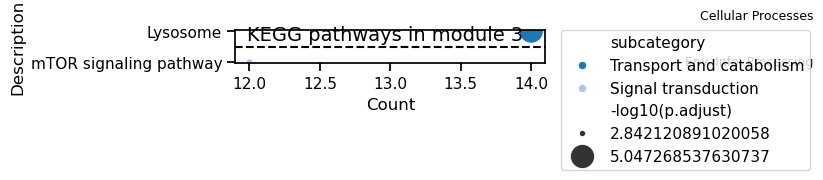

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_3.pdf
Plotting KEGG pathways for module 4


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: 
The palette list has fewer values (20) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


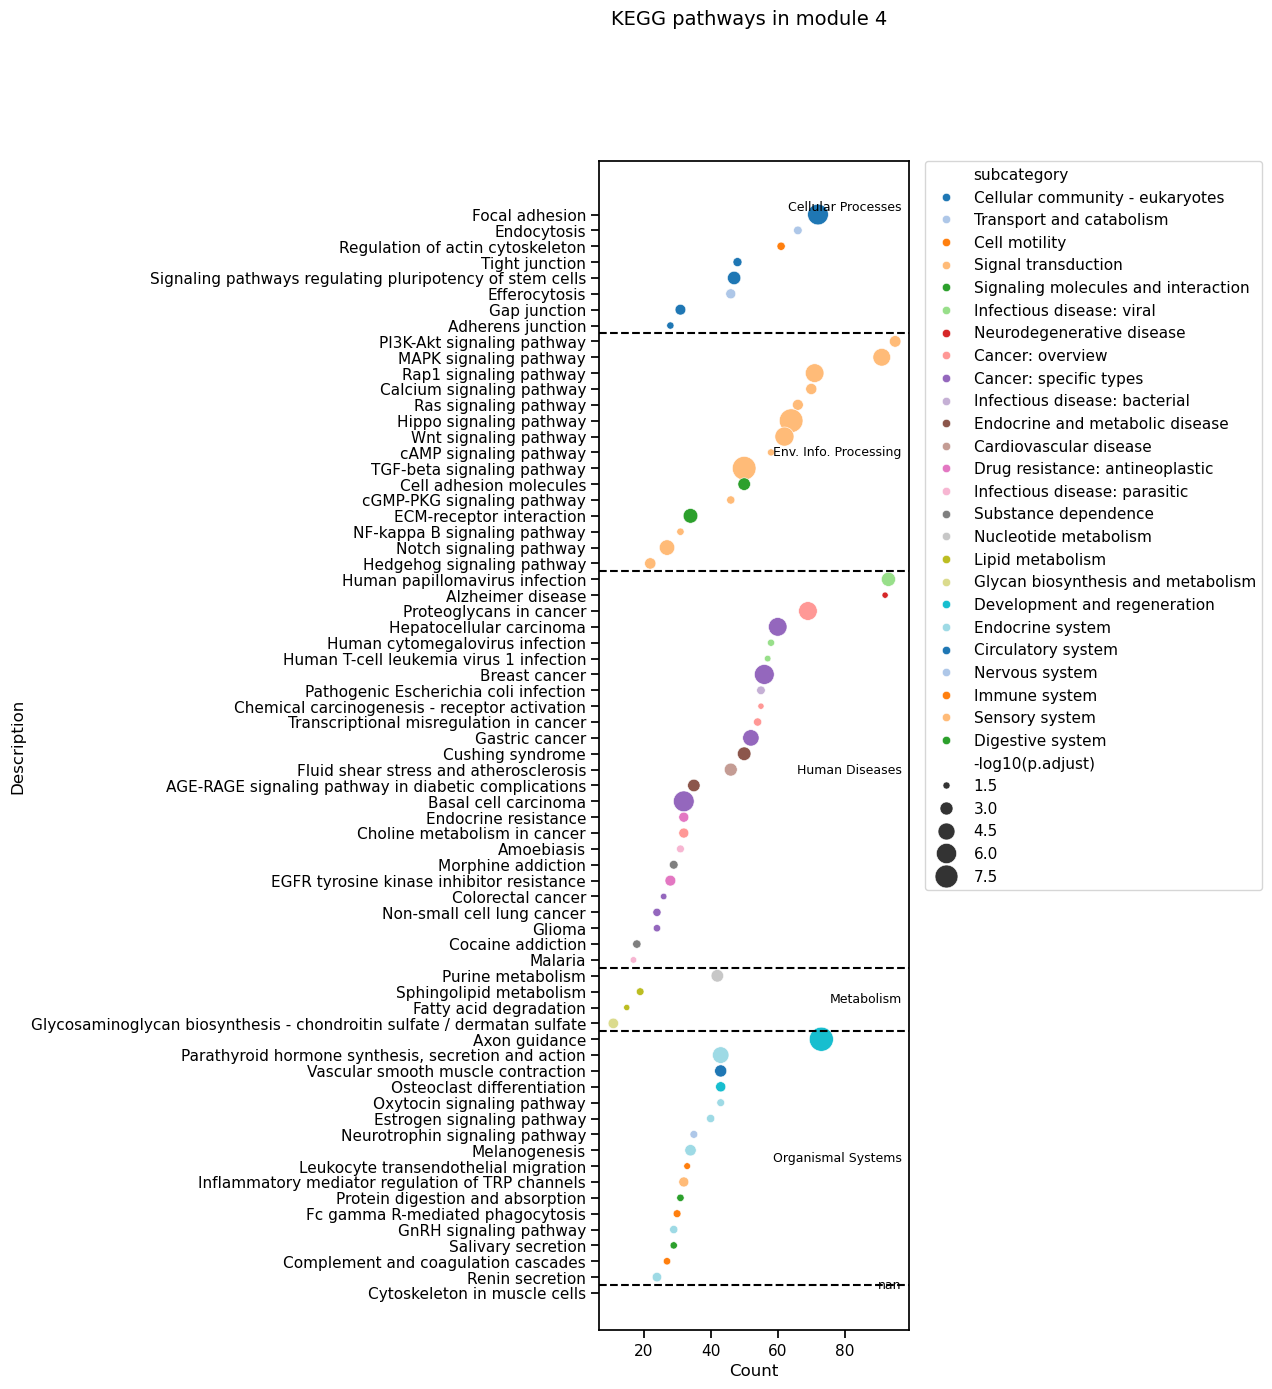

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_4.pdf
Plotting KEGG pathways for module 7


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


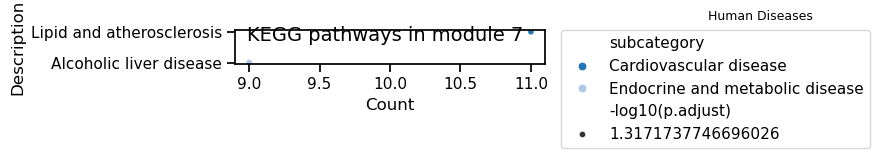

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_7.pdf
Plotting KEGG pathways for module 8


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


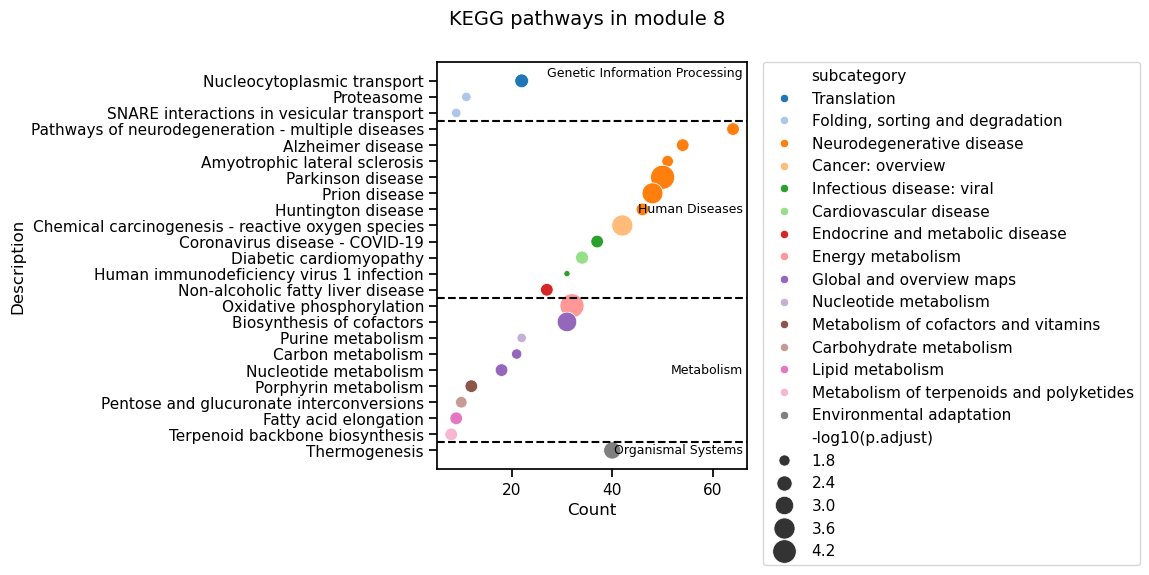

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_8.pdf
Plotting KEGG pathways for module 9


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


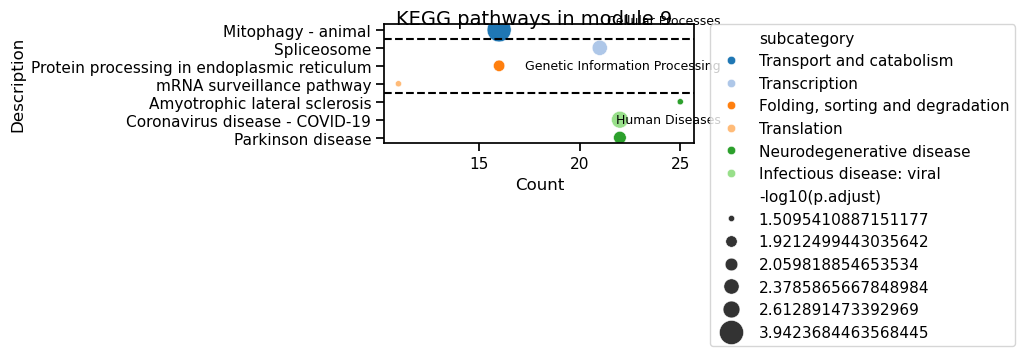

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_9.pdf
Plotting KEGG pathways for module 11


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (1), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


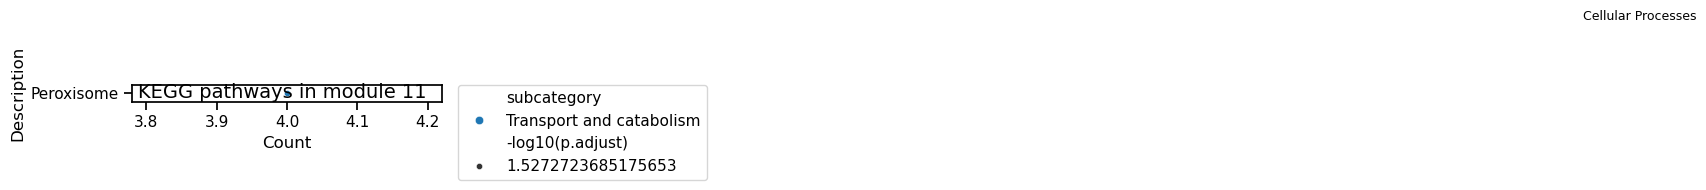

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_11.pdf


In [646]:
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]
for m in range(14):
    if len(kegg_alpaca_significant[kegg_alpaca_significant['module']==m]) > 0:
        print(f'Plotting KEGG pathways for module {m}')
        plot_pathways_kegg_module(kegg_alpaca, m, th=0.05, output_file=outputDir + f'kegg_module_{m}.pdf')

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


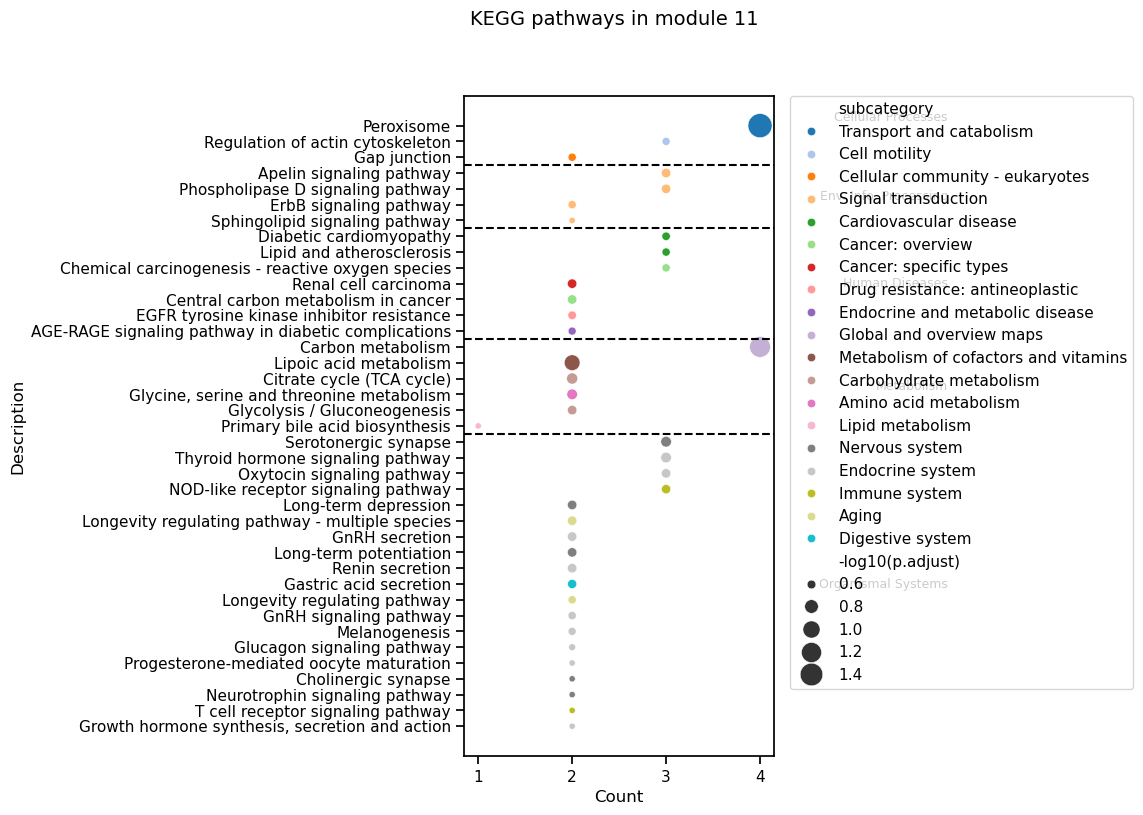

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_11.pdf


In [175]:
plot_pathways_kegg_module(kegg_alpaca,11, th=0.3, output_file=outputDir + f'kegg_module_11.pdf')

In [557]:
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]

kegg_alpaca_significant['-log10(p.adjust)'] = -np.log10(kegg_alpaca_significant['p.adjust'])
kegg_alpaca_significant = kegg_alpaca_significant.sort_values(by = ['category','subcategory','module']).dropna(subset=['subcategory'])

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2674076228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['-log10(p.adjust)'] = -np.log10(kegg_alpaca_significant['p.adjust'])


In [558]:
kegg_alpaca_significant = kegg_alpaca_significant.sort_values(by = 'category').dropna(subset=['subcategory'])
map_index = {i:k for k,i in enumerate(kegg_alpaca_significant['Description'].unique())}
kegg_alpaca_significant['i'] = kegg_alpaca_significant.Description.map(map_index)
kegg_alpaca_significant

# Can you generate a palette with a different color for each category and then subcolors of the palette for each
# subcategory?
colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys','winter','autumn']
whole_palette = {}
specific_palette = {}
i = 0
for k in kegg_alpaca_significant['category'].unique():
    print(k,i)
    whole_palette[k] = colors[i]
    if str(k) == 'nan':
        subcategories = kegg_alpaca_significant[kegg_alpaca_significant['category']==k]['subcategory'].unique()
        for j, sub in enumerate(subcategories):
            specific_palette[sub] = 'k'
    else:
        subcategories = kegg_alpaca_significant[kegg_alpaca_significant['category']==k]['subcategory'].unique()
        pal = sns.color_palette(colors[i], len(subcategories))
        for j, sub in enumerate(subcategories):
            specific_palette[sub] = pal[j]
        i = i + 1
    

# map the subcategories to the colors in specific_palette
kegg_alpaca_significant['subcategory_color'] = [specific_palette[sub] if sub in specific_palette else 'k' for sub in kegg_alpaca_significant['subcategory']]


map_nonnul_modules = {k:i for i, k in enumerate(sorted(kegg_alpaca_significant['module'].unique())) if k != 0}
kegg_alpaca_significant['module_map'] = kegg_alpaca_significant['module'].map(map_nonnul_modules)
map_nonnul_modules

Cellular Processes 0
Environmental Information Processing 1
Genetic Information Processing 2
Human Diseases 3
Metabolism 4
Organismal Systems 5


{np.int64(1): 0,
 np.int64(2): 1,
 np.int64(3): 2,
 np.int64(4): 3,
 np.int64(7): 4,
 np.int64(8): 5,
 np.int64(9): 6,
 np.int64(11): 7}

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/581196669.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


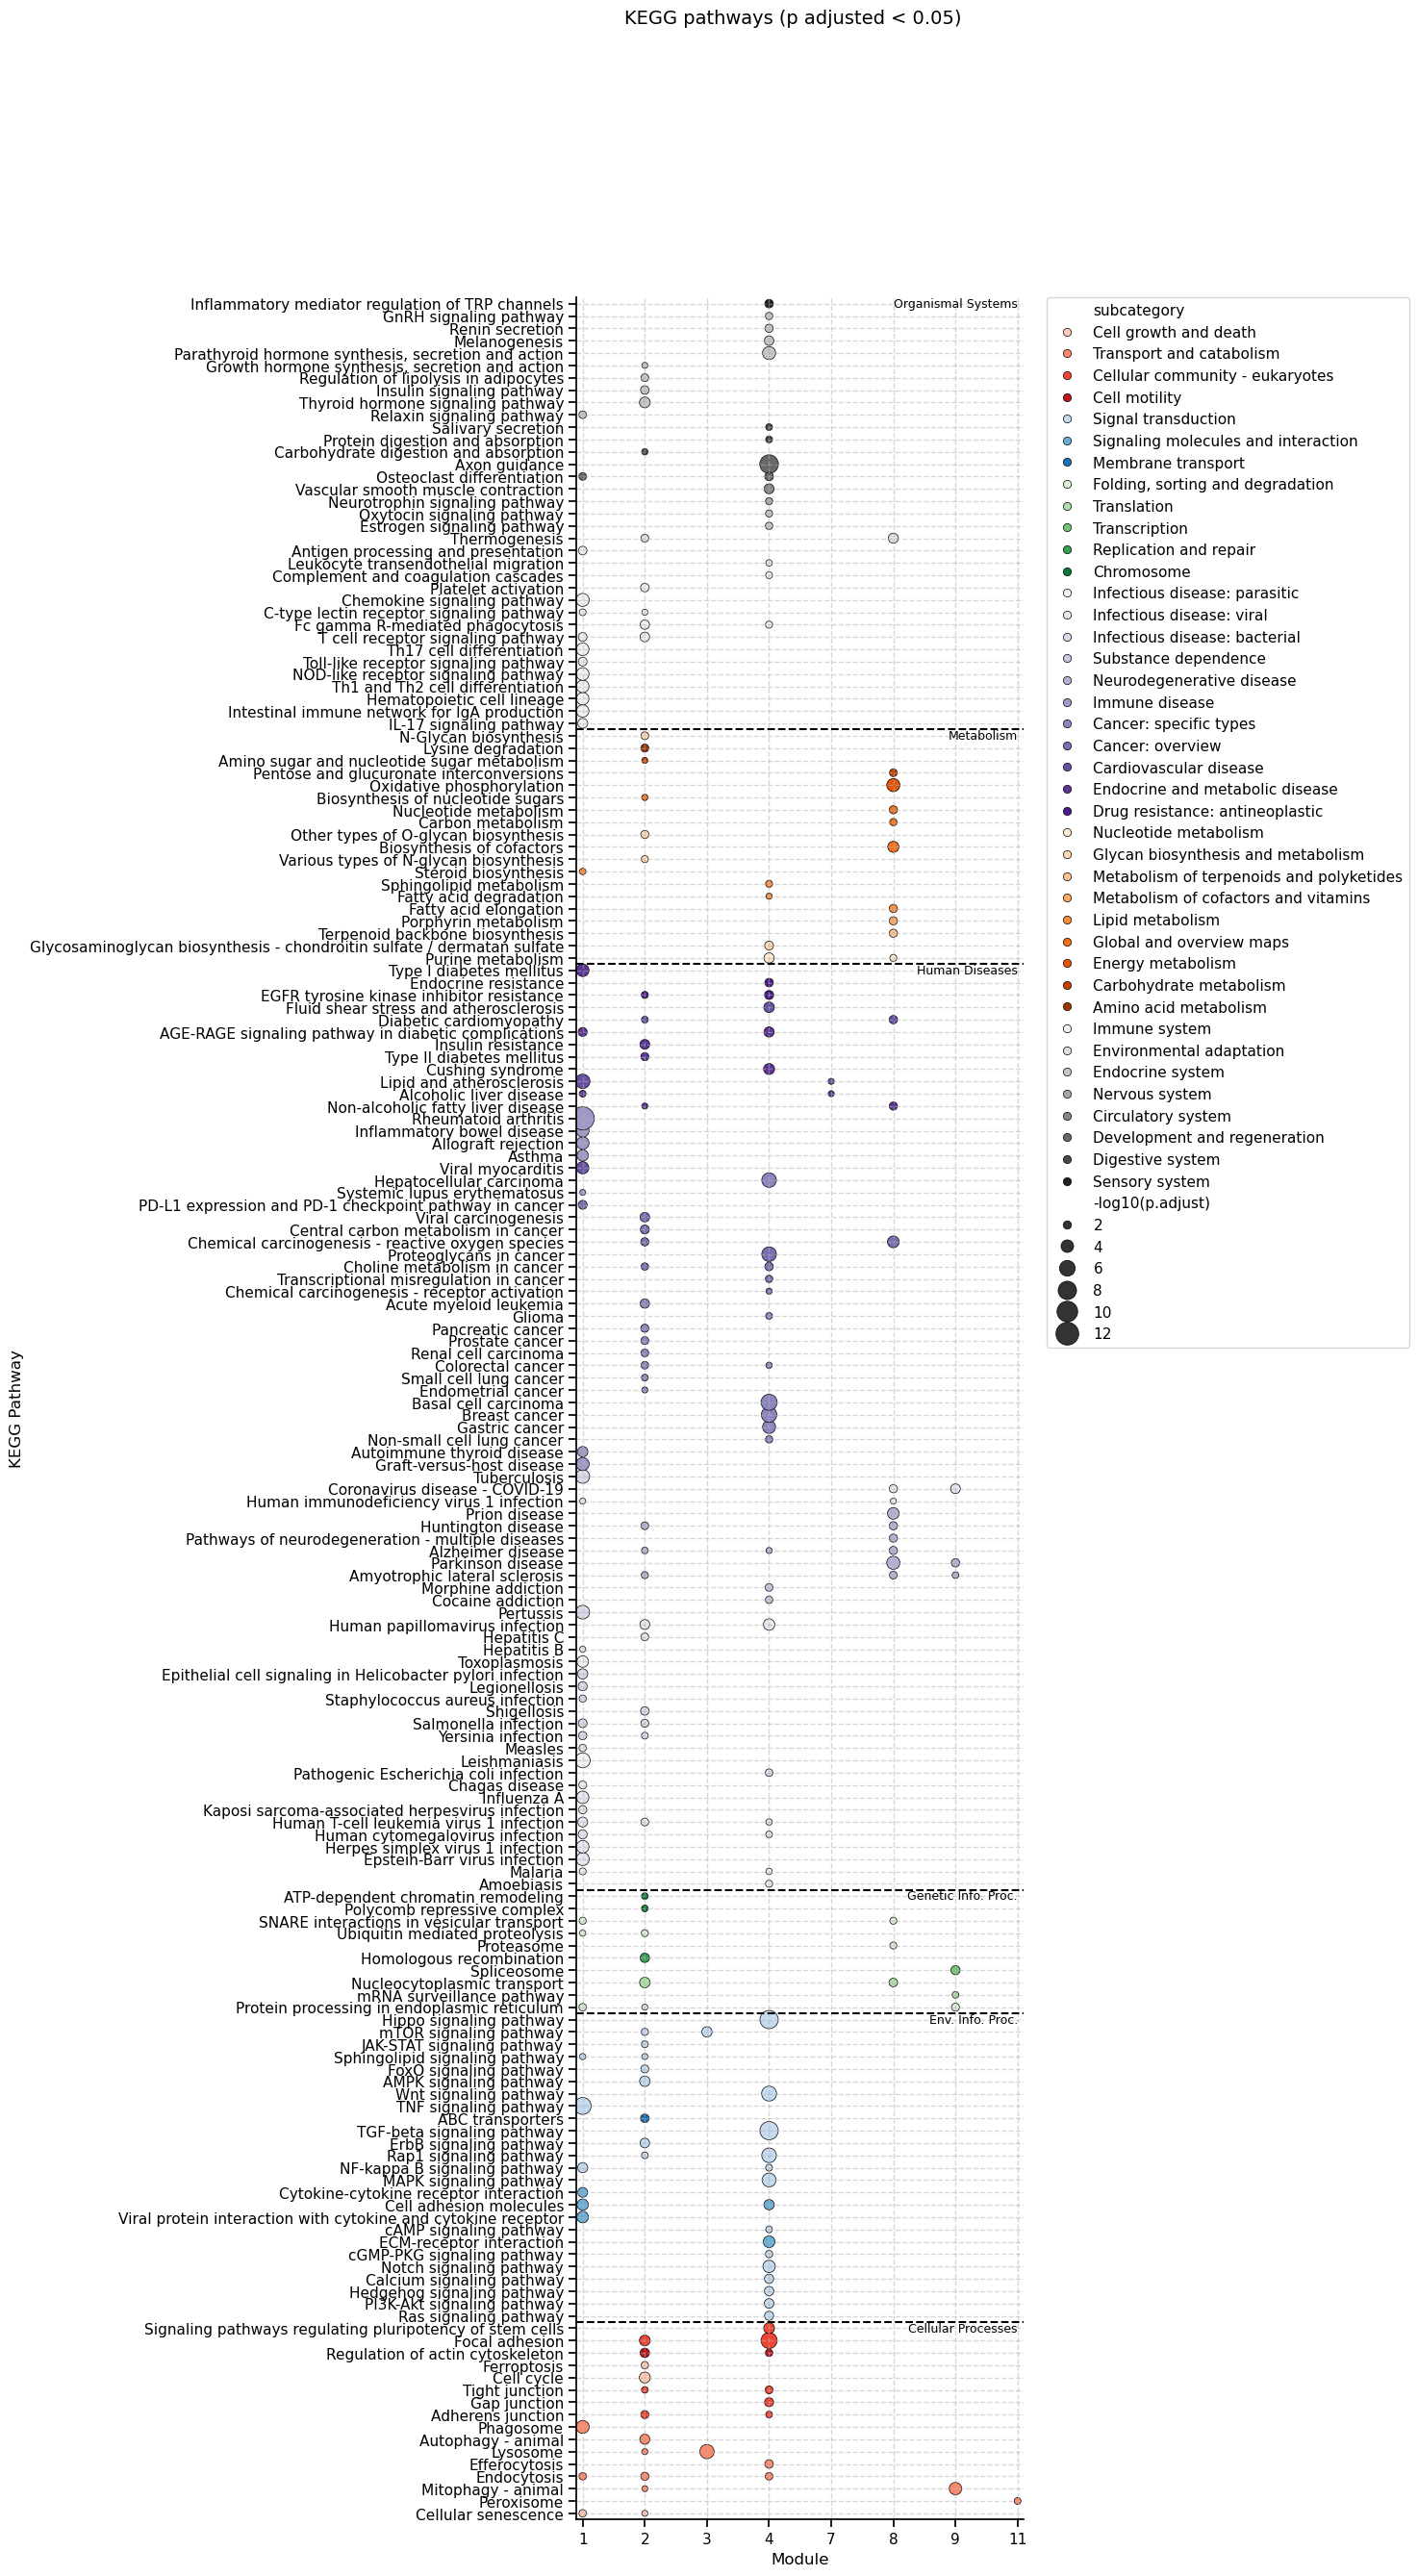

In [567]:
f, ax = plt.subplots(figsize=(6, 30))
g1 = sns.scatterplot(x='module_map', y='i', size='-log10(p.adjust)', sizes=(20, 300), data=kegg_alpaca_significant, hue='subcategory', palette=specific_palette, ax=ax, hue_order =specific_palette.keys(), alpha = 1, lw = .5, edgecolor='k')
# for the legend can you order the subcategories based on the category?
# draw row lines for each category with name on the side, you need to check how long each category is
maxx = len(map_nonnul_modules.keys())-2
for i in range(0, len(kegg_alpaca_significant)):
    temp = kegg_alpaca_significant[kegg_alpaca_significant['category'] == kegg_alpaca_significant.iloc[i]['category']]
    lrows = len(temp['i'].unique())
    if i == 0:
        ax.text(maxx+1, i+lrows -1 , kegg_alpaca_significant.iloc[i]['category'], fontsize=9, va='center', ha='right')
    else: 
        if kegg_alpaca_significant.iloc[i]['category'] != kegg_alpaca_significant.iloc[i-1]['category']:
            if kegg_alpaca_significant.iloc[i]['category']=='Environmental Information Processing':
                short = 'Env. Info. Proc.'
            elif kegg_alpaca_significant.iloc[i]['category']=='Genetic Information Processing':
                short = 'Genetic Info. Proc.'
            else:
                short = kegg_alpaca_significant.iloc[i]['category']

            ax.text(maxx+1, kegg_alpaca_significant.iloc[i]['i'] + lrows -1, short, fontsize=9, va='center', ha='right')
            ax.axhline(kegg_alpaca_significant.iloc[i]['i']-0.5, color='black', linestyle='--')
            
# legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Module')
ax.set_ylabel('KEGG Pathway')
f.suptitle('KEGG pathways (p adjusted < 0.05)', fontsize=14)
# Show all xticks betwee 1 and 14
ax.set_xticks(range(0,len(kegg_alpaca_significant['module'].unique())))
# Use the module names as xticklabels
ax.set_xticklabels([str(i) for i in sorted(kegg_alpaca_significant['module'].unique())])

# Set yticks based on the Description column
ax.set_yticks(kegg_alpaca_significant['i'].unique())
ax.set_yticklabels(map_index.keys())
# Show all xticks
# adjust y limits
# add axis grid
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(-.1, len(map_nonnul_modules.keys())-0.9)
ax.set_ylim(-0.5, len(map_index)-0.5)
# despine
sns.despine()
plt.tight_layout()

f.savefig(outputDir + f'kegg_modules_all_s005.pdf', dpi=300, bbox_inches='tight')


In [627]:
kegg_alpaca[kegg_alpaca['p.adjust'] < 0.001]

category  \
0                           Human Diseases   
1     Environmental Information Processing   
2                           Human Diseases   
3                           Human Diseases   
4                           Human Diseases   
5                           Human Diseases   
6                           Human Diseases   
7                           Human Diseases   
8                       Organismal Systems   
9                       Cellular Processes   
10                          Human Diseases   
11                          Human Diseases   
12                          Human Diseases   
13                          Human Diseases   
14                      Organismal Systems   
15                      Organismal Systems   
16                      Organismal Systems   
17                          Human Diseases   
18                      Organismal Systems   
19                      Organismal Systems   
20                          Human Diseases   
21    Environmental Information Processing   
22                          Human Diseases   
23                          Human Diseases   
24    Environmental Information Processing   
342                     Cellular Processes   
343                     Organismal Systems   
344                     Cellular Processes   
680                     Cellular Processes   
953                     Organismal Systems   
954   Environmental Information Processing   
955   Environmental Information Processing   
956                                    NaN   
957                         Human Diseases   
958                     Cellular Processes   
959                         Human Diseases   
960   Environmental Information Processing   
961                         Human Diseases   
962   Environmental Information Processing   
963                         Human Diseases   
964   Environmental Information Processing   
965                     Organismal Systems   
966                         Human Diseases   
967   Environmental Information Processing   
968   Environmental Information Processing   
969                         Human Diseases   
970                         Human Diseases   
971                     Cellular Processes   
2158                            Metabolism   
2159                        Human Diseases   
2160                        Human Diseases   
2161                        Human Diseases   
2162                            Metabolism   
2494                    Cellular Processes   

                              subcategory        ID  \
0                          Immune disease  hsa05323   
1                     Signal transduction  hsa04668   
2           Infectious disease: parasitic  hsa05140   
3                  Cardiovascular disease  hsa05417   
4           Infectious disease: bacterial  hsa05152   
5           Infectious disease: bacterial  hsa05133   
6                          Immune disease  hsa05332   
7               Infectious disease: viral  hsa05169   
8                           Immune system  hsa04062   
9                Transport and catabolism  hsa04145   
10                         Immune disease  hsa05321   
11                         Immune disease  hsa05330   
12              Infectious disease: viral  hsa05168   
13        Endocrine and metabolic disease  hsa04940   
14                          Immune system  hsa04658   
15                          Immune system  hsa04621   
16                          Immune system  hsa04659   
17              Infectious disease: viral  hsa05164   
18                          Immune system  hsa04640   
19                          Immune system  hsa04672   
20                 Cardiovascular disease  hsa05416   
21    Signaling molecules and interaction  hsa04061   
22          Infectious disease: parasitic  hsa05145   
23                         Immune disease  hsa05310   
24    Signaling molecules and interaction  hsa04514   
342                 Cell growth and death  hsa04110   
343               

In [634]:
kegg_alpaca_significant['subcategory'].fillna('Other')

0                            Immune disease
1                       Signal transduction
2             Infectious disease: parasitic
3                    Cardiovascular disease
4             Infectious disease: bacterial
5             Infectious disease: bacterial
6                            Immune disease
7                 Infectious disease: viral
8                             Immune system
9                  Transport and catabolism
10                           Immune disease
11                           Immune disease
12                Infectious disease: viral
13          Endocrine and metabolic disease
14                            Immune system
15                            Immune system
16                            Immune system
17                Infectious disease: viral
18                            Immune system
19                            Immune system
20                   Cardiovascular disease
21      Signaling molecules and interaction
22            Infectious disease

In [637]:
kegg_alpaca_significant

category  \
0                           Human Diseases   
1     Environmental Information Processing   
2                           Human Diseases   
3                           Human Diseases   
4                           Human Diseases   
5                           Human Diseases   
6                           Human Diseases   
7                           Human Diseases   
8                       Organismal Systems   
9                       Cellular Processes   
10                          Human Diseases   
11                          Human Diseases   
12                          Human Diseases   
13                          Human Diseases   
14                      Organismal Systems   
15                      Organismal Systems   
16                      Organismal Systems   
17                          Human Diseases   
18                      Organismal Systems   
19                      Organismal Systems   
20                          Human Diseases   
21    Environmental Information Processing   
22                          Human Diseases   
23                          Human Diseases   
24    Environmental Information Processing   
342                     Cellular Processes   
343                     Organismal Systems   
344                     Cellular Processes   
680                     Cellular Processes   
953                     Organismal Systems   
954   Environmental Information Processing   
955   Environmental Information Processing   
956                                    NaN   
957                         Human Diseases   
958                     Cellular Processes   
959                         Human Diseases   
960   Environmental Information Processing   
961                         Human Diseases   
962   Environmental Information Processing   
963                         Human Diseases   
964   Environmental Information Processing   
965                     Organismal Systems   
966                         Human Diseases   
967   Environmental Information Processing   
968   Environmental Information Processing   
969                         Human Diseases   
970                         Human Diseases   
971                     Cellular Processes   
2158                            Metabolism   
2159                        Human Diseases   
2160                        Human Diseases   
2161                        Human Diseases   
2162                            Metabolism   
2494                    Cellular Processes   

                              subcategory        ID  \
0                          Immune disease  hsa05323   
1                     Signal transduction  hsa04668   
2           Infectious disease: parasitic  hsa05140   
3                  Cardiovascular disease  hsa05417   
4           Infectious disease: bacterial  hsa05152   
5           Infectious disease: bacterial  hsa05133   
6                          Immune disease  hsa05332   
7               Infectious disease: viral  hsa05169   
8                           Immune system  hsa04062   
9                Transport and catabolism  hsa04145   
10                         Immune disease  hsa05321   
11                         Immune disease  hsa05330   
12              Infectious disease: viral  hsa05168   
13        Endocrine and metabolic disease  hsa04940   
14                          Immune system  hsa04658   
15                          Immune system  hsa04621   
16                          Immune system  hsa04659   
17              Infectious disease: viral  hsa05164   
18                          Immune system  hsa04640   
19                          Immune system  hsa04672   
20                 Cardiovascular disease  hsa05416   
21    Signaling molecules and interaction  hsa04061   
22          Infectious disease: parasitic  hsa05145   
23                         Immune disease  hsa05310   
24    Signaling molecules and interaction  hsa04514   
342                 Cell growth and death  hsa04110   
343               

In [642]:
# Can you do a plot where you count the number of significant pathways per module and per subcategorty?
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]
kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].fillna('Other')
kegg_alpaca_significant['category'] = kegg_alpaca_significant['category'].fillna('Other')
kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].astype('str')
kegg_alpaca_significant['n_pathways'] = 1
kegg_alpaca_count = kegg_alpaca_significant.groupby(['module', 'subcategory']).agg({'n_pathways': 'sum'}).reset_index()
kegg_alpaca_count = kegg_alpaca_count.sort_values(by=['module', 'subcategory'])
kegg_alpaca_count['module'] = kegg_alpaca_count['module'].astype('str')
# map the subcategories to the categories
kegg_alpaca_count['category'] = kegg_alpaca_count['subcategory'].map(kegg_alpaca_significant.set_index('subcategory')['category'].to_dict())
kegg_alpaca_count.sort_values(by=['module', 'subcategory'], inplace=True)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/843739742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].fillna('Other')
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/843739742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['category'] = kegg_alpaca_significant['category'].fillna('Other')
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/8437397

In [ ]:
# Create a color palette for the subcategories that assigns a unique color to each category:

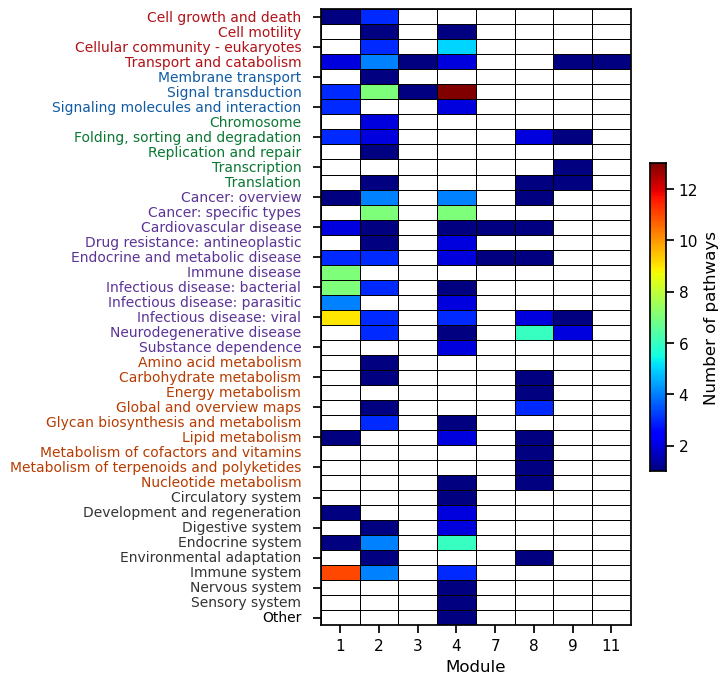

In [643]:
subdf = pd.pivot_table(kegg_alpaca_count.sort_values(by = ['category','module']), values='n_pathways', index='module', columns='subcategory', fill_value=0).T
subdf.columns = [int(i) for i in subdf.columns]
subdf = subdf.reindex(sorted(subdf.columns), axis=1)  # Sort columns alphabetically
# Order the rows by category
subdf = subdf.reindex(sorted(subdf.index, key=lambda x: kegg_alpaca_significant[kegg_alpaca_significant['subcategory'] == x]['category'].unique()[0]), axis=0)
# Make the colorbar smaller
f, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(subdf, cmap='jet', cbar_kws={'label': 'Number of pathways', 'shrink':0.5}, linewidths=.5, linecolor='black', mask = (subdf==0))
ax.set_yticklabels([])
# Color the ytick labels with the category colors, use the category not the subcategory

for i, cat in enumerate(subdf.index):
    category = kegg_alpaca_significant.set_index('subcategory')['category'].to_dict()[cat]
    if category != 'Other':
        pal = whole_palette[category]
        color = sns.color_palette(pal, 5)[-1]
    else:
        color = 'k'
    if cat in specific_palette:
        ax.text(-0.5, i+0.5, cat, color=color, fontsize=10, va='center', ha='right')
    else:
        ax.text(-0.5, i+0.5, cat, color=color, fontsize=10, va='center', ha='right')

ax.set_ylabel("")
ax.set_xlabel("Module")

# add spines
sns.despine(left=False, bottom=False, right=False, top=False)

f.savefig(outputDir + 'kegg_modules_count.pdf', dpi=300, bbox_inches='tight')

In [619]:
kegg_alpaca_count

module                      subcategory  n_pathways  \
0       1                 Cancer: overview           1   
1       1           Cardiovascular disease           2   
2       1            Cell growth and death           1   
3       1     Development and regeneration           1   
4       1  Endocrine and metabolic disease           3   
..    ...                              ...         ...   
88      9        Neurodegenerative disease           2   
89      9                    Transcription           1   
90      9                      Translation           1   
91      9         Transport and catabolism           1   
92     11         Transport and catabolism           1   

                          category  
0                   Human Diseases  
1                   Human Diseases  
2               Cellular Processes  
3               Organismal Systems  
4                   Human Diseases  
..                             ...  
88                  Human Diseases  
89  Genetic Information Processing  
90  Genetic Information Processing  
91              Cellular Processes  
92              Cellular Processes  

[93 rows x 4 columns]

## Comparison with DRAGON clusters

In [176]:
membership

node  module  modularity        node_name node_type  \
0                 ALX1_A       1    0.006097             ALX1         A   
1                 ALX3_A       2    0.011064             ALX3         A   
2                 ALX4_A       1    0.005248             ALX4         A   
3                   AR_A       2    0.001445               AR         A   
4                ARGFX_A       2    0.012254            ARGFX         A   
...                  ...     ...         ...              ...       ...   
20641  ENSG00000253451_B       8    0.000065  ENSG00000253451         B   
20642  ENSG00000278020_B       8    0.000120  ENSG00000278020         B   
20643  ENSG00000148926_B       1    0.000090  ENSG00000148926         B   
20644  ENSG00000146477_B       4    0.000040  ENSG00000146477         B   
20645  ENSG00000273329_B       8   -0.000012  ENSG00000273329         B   

         gene_symbol  
0               ALX1  
1               ALX3  
2               ALX4  
3                 AR  
4              ARGFX  
...              ...  
20641       IGLV2-28  
20642   HOXA11-AS1_6  
20643            ADM  
20644        SLC22A3  
20645  RP11-448A19.1  

[20646 rows x 6 columns]

In [177]:
# import all functions from utils.py that is inside src folder
from src.utils import *

In [178]:
dragon_fn = {'cms1':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/dragon/tcga_coad_cms1_dragon_mat.tsv',
             'cms2':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_dragon_mat.tsv',
             'cms3':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/dragon/tcga_coad_cms3_dragon_mat.tsv',
             'cms4':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_dragon_mat.tsv'}
             

In [179]:
# Read the dragons with the function from utils.py
dragons = read_dragons(dragon_fn)

cms1
cms2
cms3
cms4


In [180]:
# to keep track of all the edges we will create a dataframe where subtypes are in the columns and rows are the edges
# For simplicity we write down the order of the subtypes
subtype_order = ['cms2','cms4']
dragon = get_long_dragon(dragons)
dragon.head()

                        level_0                 level_1         0
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_methylation  0.001609
2        AC023509.3_methylation       AEBP1_methylation -0.001914
3        AC023509.3_methylation       AEBP2_methylation  0.002398
4        AC023509.3_methylation       AHDC1_methylation  0.004454
...                         ...                     ...       ...
1006066      ZSCAN22_expression         ZXDB_expression  0.000783
1006067      ZSCAN22_expression         ZXDC_expression  0.003939
1006068       ZSCAN9_expression         ZXDB_expression -0.000765
1006069       ZSCAN9_expression         ZXDC_expression  0.000768
1006070         ZXDB_expression         ZXDC_expression  0.000498

[1006071 rows x 3 columns]
                          node1                   node2      cms1
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_meth

node1                   node2      cms1      cms2  \
0  AC023509.3_methylation  AC092835.1_methylation  0.010079 -0.002448   
1  AC023509.3_methylation  AC138696.1_methylation  0.001609  0.008164   
2  AC023509.3_methylation        AEBP1_expression -0.005313  0.002291   
3  AC023509.3_methylation       AEBP1_methylation -0.001914 -0.004333   
4  AC023509.3_methylation        AEBP2_expression  0.001178  0.001567   

       cms3      cms4  
0 -0.012452  0.011108  
1  0.006137  0.004494  
2  0.003407 -0.005202  
3  0.000148  0.002592  
4  0.001819  0.001794

In [181]:
# mean dragon value for all subtypes
dragon['mean']  = dragon.loc[:,subtype_order].mean(axis =1)
# absolute mean dragon value for all subtypes
dragon['abs_mean']  = np.abs(dragon.loc[:,subtype_order]).mean(axis =1)
# variance
dragon['var']  = dragon.loc[:,subtype_order].var(axis =1)

# node type, whether expression or methylation
dragon['node1_type'] = [i.split('_')[1] for i in dragon['node1']]
dragon['node2_type'] = [i.split('_')[1] for i in dragon['node2']]
# node name
dragon['node1_tf'] = [i.split('_')[0] for i in dragon['node1']]
dragon['node2_tf'] = [i.split('_')[0] for i in dragon['node2']]

# get absolute values for dragons
dragon.loc[:,[i+'_abs' for i in subtype_order]] = np.abs(dragon.loc[:,subtype_order].values)

# edge name
dragon['edge'] = dragon.node1_tf +'-'+ dragon.node2_tf
dragon = dragon.set_index('edge')
# select same TF edges
dragon['same'] = 1*(dragon.node1_tf == dragon.node2_tf)
dragon.sort_values(by = 'mean', ascending = False)

node1               node2      cms1      cms2  \
edge                                                                        
ZNF646-ZNF668  ZNF646_methylation  ZNF668_methylation  0.054987  0.066278   
HOXA5-HOXA6     HOXA5_methylation   HOXA6_methylation  0.023401  0.053203   
ZNF41-ZNF674    ZNF41_methylation  ZNF674_methylation  0.035610  0.047834   
ELF4-ZNF81       ELF4_methylation   ZNF81_methylation  0.034261  0.047164   
ZNF41-ZNF81     ZNF41_methylation   ZNF81_methylation  0.035081  0.047223   
...                           ...                 ...       ...       ...   
ZXDC-NFIB        ZXDC_methylation     NFIB_expression       NaN       NaN   
ZXDC-RFX6        ZXDC_methylation     RFX6_expression       NaN       NaN   
ZXDC-RORA        ZXDC_methylation     RORA_expression  0.004828       NaN   
ZXDC-SIX4        ZXDC_methylation     SIX4_expression       NaN       NaN   
ZXDC-TBX21       ZXDC_methylation    TBX21_expression  0.001992       NaN   

                   cms3      cms4      mean  abs_mean           var  \
edge                                                                  
ZNF646-ZNF668  0.052999  0.066142  0.066210  0.066210  9.201835e-09   
HOXA5-HOXA6    0.041463  0.060362  0.056782  0.056782  2.562438e-05   
ZNF41-ZNF674   0.043143  0.044130  0.045982  0.045982  6.860125e-06   
ELF4-ZNF81     0.042864  0.044439  0.045802  0.045802  3.713136e-06   
ZNF41-ZNF81    0.042872  0.044226  0.045725  0.045725  4.491069e-06   
...                 ...       ...       ...       ...           ...   
ZXDC-NFIB     -0.006304       NaN       NaN       NaN           NaN   
ZXDC-RFX6      0.002027       NaN       NaN       NaN           NaN   
ZXDC-RORA     -0.002228       NaN       NaN       NaN           NaN   
ZXDC-SIX4     -0.000900       NaN       NaN       NaN           NaN   
ZXDC-TBX21          NaN       NaN       NaN       NaN           NaN   

                node1_type   node2_type node1_tf node2_tf  cms2_abs  cms4_abs  \
edge                                                                            
ZNF646-ZNF668  methylation  methylation   ZNF646   ZNF668  0.066278  0.066142   
HOXA5-HOXA6    methylation  methylation    HOXA5    HOXA6  0.053203  0.060362   
ZNF41-ZNF674   methylation  methylation    ZNF41   ZNF674  0.047834  0.044130   
ELF4-ZNF81     methylation  methylation     ELF4    ZNF81  0.047164  0.044439   
ZNF41-ZNF81    methylation  methylation    ZNF41    ZNF81  0.047223  0.044226   
...                    ...          ...      ...      ...       ...       ...   
ZXDC-NFIB      methylation   expression     ZXDC     NFIB       NaN       NaN   
ZXDC-RFX6      methylation   expression     ZXDC     RFX6       NaN       NaN   
ZXDC-RORA      methylation   expression     ZXDC     RORA       NaN       NaN   
ZXDC-SIX4      methylation   expression     ZXDC     SIX4       NaN       NaN   
ZXDC-TBX21     methylation   expression     ZXDC    TBX21       NaN       NaN   

               same  
edge                 
ZNF646-ZNF668     0  
HOXA5-HOXA6       0  
ZNF41-ZNF674      0  
ELF4-ZNF81        0  
ZNF41-ZNF81       0  
...             ...  
ZXDC-NFIB         0  
ZXDC-RFX6         0  
ZXDC-RORA         0  
ZXDC-SIX4         0  
ZXDC-TBX21        0  

[1067100 rows x 16 columns]

In [182]:
# Get only methylation to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2      cms1  \
edge                                                                     
AC023509.3-AEBP1   AC023509.3_methylation   AEBP1_expression -0.005313   
AC023509.3-AEBP2   AC023509.3_methylation   AEBP2_expression  0.001178   
AC023509.3-AHDC1   AC023509.3_methylation   AHDC1_expression -0.002381   
AC023509.3-AHR     AC023509.3_methylation     AHR_expression       NaN   
AC023509.3-AKAP8L  AC023509.3_methylation  AKAP8L_expression -0.001239   

                       cms2      cms3      cms4      mean  abs_mean  \
edge                                                                  
AC023509.3-AEBP1   0.002291  0.003407 -0.005202 -0.001455  0.003747   
AC023509.3-AEBP2   0.001567  0.001819  0.001794  0.001681  0.001681   
AC023509.3-AHDC1  -0.005991 -0.001529 -0.001857 -0.003924  0.003924   
AC023509.3-AHR          NaN -0.002166       NaN       NaN       NaN   
AC023509.3-AKAP8L  0.003665 -0.004399  0.005655  0.004660  0.004660   

                            var   node1_type  node2_type    node1_tf node2_tf  \
edge                                                                            
AC023509.3-AEBP1   2.807274e-05  methylation  expression  AC023509.3    AEBP1   
AC023509.3-AEBP2   2.580415e-08  methylation  expression  AC023509.3    AEBP2   
AC023509.3-AHDC1   8.547863e-06  methylation  expression  AC023509.3    AHDC1   
AC023509.3-AHR              NaN  methylation  expression  AC023509.3      AHR   
AC023509.3-AKAP8L  1.979502e-06  methylation  expression  AC023509.3   AKAP8L   

                   cms2_abs  cms4_abs  same  
edge                                         
AC023509.3-AEBP1   0.002291  0.005202     0  
AC023509.3-AEBP2   0.001567  0.001794     0  
AC023509.3-AHDC1   0.005991  0.001857     0  
AC023509.3-AHR          NaN       NaN     0  
AC023509.3-AKAP8L  0.003665  0.005655     0

In [183]:
# Add binary label on whether the TFs are the same
sns.set_context('paper', font_scale = 1.5)
dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2537370692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)


In [185]:
dragon_direct = dragon_trans[dragon_trans['same TF']==True]
dragon_direct.head()

node1              node2      cms1      cms2  \
edge                                                                       
AEBP1-AEBP1     AEBP1_methylation   AEBP1_expression -0.002624  0.000903   
AEBP2-AEBP2     AEBP2_methylation   AEBP2_expression -0.001224 -0.018277   
AHDC1-AHDC1     AHDC1_methylation   AHDC1_expression -0.002131 -0.001279   
AHR-AHR           AHR_methylation     AHR_expression       NaN       NaN   
AKAP8L-AKAP8L  AKAP8L_methylation  AKAP8L_expression -0.003496  0.001071   

                   cms3      cms4      mean  abs_mean           var  \
edge                                                                  
AEBP1-AEBP1   -0.002126  0.000925  0.000914  0.000914  2.353771e-10   
AEBP2-AEBP2   -0.005222 -0.007302 -0.012789  0.012789  6.022419e-05   
AHDC1-AHDC1   -0.004359 -0.000836 -0.001058  0.001058  9.814707e-08   
AHR-AHR       -0.007369       NaN       NaN       NaN           NaN   
AKAP8L-AKAP8L -0.001479 -0.002993 -0.000961  0.002032  8.257889e-06   

                node1_type  node2_type node1_tf node2_tf  cms2_abs  cms4_abs  \
edge                                                                           
AEBP1-AEBP1    methylation  expression    AEBP1    AEBP1  0.000903  0.000925   
AEBP2-AEBP2    methylation  expression    AEBP2    AEBP2  0.018277  0.007302   
AHDC1-AHDC1    methylation  expression    AHDC1    AHDC1  0.001279  0.000836   
AHR-AHR        methylation  expression      AHR      AHR       NaN       NaN   
AKAP8L-AKAP8L  methylation  expression   AKAP8L   AKAP8L  0.001071  0.002993   

               same  same TF  
edge                          
AEBP1-AEBP1       1     True  
AEBP2-AEBP2       1     True  
AHDC1-AHDC1       1     True  
AHR-AHR           1     True  
AKAP8L-AKAP8L     1     True

In [186]:
th = 0.1 #quantile threshold

for key in subtype_order:
    threshold = dragon_direct[key].dropna().quantile(th)
    print(key, threshold)
    dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
dragon_direct['lower'] = np.sum(dragon_direct.loc[:,[key+'_lower' for key in subtype_order]], axis = 1)
dragon_direct.sort_values(by = 'lower', ascending = True)


cms2 -0.01590839262254296
cms4 -0.01560371809056855


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:7: SettingWithCopyWarning: 
A value is trying to be set

node1              node2      cms1      cms2  \
edge                                                                       
AEBP1-AEBP1     AEBP1_methylation   AEBP1_expression -0.002624  0.000903   
TFDP1-TFDP1     TFDP1_methylation   TFDP1_expression -0.005131  0.001965   
TFEC-TFEC        TFEC_methylation    TFEC_expression  0.000359 -0.005376   
TGIF2-TGIF2     TGIF2_methylation   TGIF2_expression -0.001997 -0.007947   
THAP11-THAP11  THAP11_methylation  THAP11_expression  0.000046 -0.003226   
...                           ...                ...       ...       ...   
HMGA1-HMGA1     HMGA1_methylation   HMGA1_expression -0.001636 -0.025991   
ZNF28-ZNF28     ZNF28_methylation   ZNF28_expression -0.013064 -0.025394   
ZNF532-ZNF532  ZNF532_methylation  ZNF532_expression -0.009346 -0.021969   
STAT5A-STAT5A  STAT5A_methylation  STAT5A_expression -0.015136 -0.023906   
ZNF329-ZNF329  ZNF329_methylation  ZNF329_expression -0.015340 -0.019992   

                   cms3      cms4      mean  abs_mean           var  \
edge                                                                  
AEBP1-AEBP1   -0.002126  0.000925  0.000914  0.000914  2.353771e-10   
TFDP1-TFDP1    0.003104 -0.005021 -0.001528  0.003493  2.440276e-05   
TFEC-TFEC     -0.000557  0.001816 -0.001780  0.003596  2.586179e-05   
TGIF2-TGIF2   -0.007138  0.006296 -0.000825  0.007121  1.014306e-04   
THAP11-THAP11 -0.001396 -0.001129 -0.002178  0.002178  2.197109e-06   
...                 ...       ...       ...       ...           ...   
HMGA1-HMGA1   -0.009637 -0.015608 -0.020799  0.020799  5.390584e-05   
ZNF28-ZNF28   -0.015258 -0.032571 -0.028983  0.028983  2.575722e-05   
ZNF532-ZNF532 -0.011497 -0.016304 -0.019136  0.019136  1.604242e-05   
STAT5A-STAT5A -0.015194 -0.019534 -0.021720  0.021720  9.556921e-06   
ZNF329-ZNF329 -0.012791 -0.023334 -0.021663  0.021663  5.584685e-06   

                node1_type  node2_type node1_tf node2_tf  cms2_abs  cms4_abs  \
edge                                                                           
AEBP1-AEBP1    methylation  expression    AEBP1    AEBP1  0.000903  0.000925   
TFDP1-TFDP1    methylation  expression    TFDP1    TFDP1  0.001965  0.005021   
TFEC-TFEC      methylation  expression     TFEC     TFEC  0.005376  0.001816   
TGIF2-TGIF2    methylation  expression    TGIF2    TGIF2  0.007947  0.006296   
THAP11-THAP11  methylation  expression   THAP11   THAP11  0.003226  0.001129   
...                    ...         ...      ...      ...       ...       ...   
HMGA1-HMGA1    methylation  expression    HMGA1    HMGA1  0.025991  0.015608   
ZNF28-ZNF28    methylation  expression    ZNF28    ZNF28  0.025394  0.032571   
ZNF532-ZNF532  methylation  expression   ZNF532   ZNF532  0.021969  0.016304   
STAT5A-STAT5A  methylation  expression   STAT5A   STAT5A  0.023906  0.019534   
ZNF329-ZNF329  methylation  expression   ZNF329   ZNF329  0.019992  0.023334   

               same  same TF  cms2_lower  cms4_lower  lower  
edge                                                         
AEBP1-AEBP1       1     True       False       False      0  
TFDP1-TFDP1       1     True       False       False      0  
TFEC-TFEC         1     True       False       False      0  
TGIF2-TGIF2       1     True       False       False      0  
THAP11-THAP11     1     True       False       False      0  
...             ...      ...         ...         ...    ...  
HMGA1-HMGA1       1     True        True        True      2  
ZNF28-ZNF28       1     True        True        True      2  
ZNF532-ZNF532     1     True        True        True      2  
STAT5A-STAT5A     1     True        True        True      2  
ZNF329-ZNF329     1     True        True        True      2  

[656 rows x 20 columns]

In [187]:
membership_dragon = membership_tf.merge(dragon_direct, left_on='node_name', right_on='node1_tf', how = 'inner')
membership_dragon

node  module  modularity node_name node_type gene_symbol  n_tf  \
0       ALX3_A       2    0.011064      ALX3         A        ALX3   243   
1         AR_A       2    0.001445        AR         A          AR   243   
2     ARID3A_A       1    0.005118    ARID3A         A      ARID3A   251   
3        ARX_A       2    0.006048       ARX         A         ARX   243   
4      ASCL2_A       4    0.003271     ASCL2         A       ASCL2   267   
..         ...     ...         ...       ...       ...         ...   ...   
415   ZNF860_A       4    0.007344    ZNF860         A      ZNF860   267   
416   ZNF880_A       4    0.010618    ZNF880         A      ZNF880   267   
417  ZSCAN16_A       4    0.000670   ZSCAN16         A     ZSCAN16   267   
418  ZSCAN22_A       4    0.004847   ZSCAN22         A     ZSCAN22   267   
419   ZSCAN9_A       1    0.002776    ZSCAN9         A      ZSCAN9   251   

     raw_modularity                node1               node2  ...  node2_type  \
0          2.688537     ALX3_methylation     ALX3_expression  ...  expression   
1          0.351055       AR_methylation       AR_expression  ...  expression   
2          1.284610   ARID3A_methylation   ARID3A_expression  ...  expression   
3          1.469776      ARX_methylation      ARX_expression  ...  expression   
4          0.873283    ASCL2_methylation    ASCL2_expression  ...  expression   
..              ...                  ...                 ...  ...         ...   
415        1.960922   ZNF860_methylation   ZNF860_expression  ...  expression   
416        2.835030   ZNF880_methylation   ZNF880_expression  ...  expression   
417        0.178955  ZSCAN16_methylation  ZSCAN16_expression  ...  expression   
418        1.294188  ZSCAN22_methylation  ZSCAN22_expression  ...  expression   
419        0.696806   ZSCAN9_methylation   ZSCAN9_expression  ...  expression   

     node1_tf  node2_tf  cms2_abs  cms4_abs  same  same TF cms2_lower  \
0        ALX3      ALX3  0.005941  0.004733     1     True      False   
1          AR        AR  0.011389  0.003888     1     True      False   
2      ARID3A    ARID3A  0.002613  0.001389     1     True      False   
3         ARX       ARX       NaN       NaN     1     True      False   
4       ASCL2     ASCL2  0.011671  0.004720     1     True      False   
..        ...       ...       ...       ...   ...      ...        ...   
415    ZNF860    ZNF860  0.004005  0.009546     1     True      False   
416    ZNF880    ZNF880  0.033981  0.026928     1     True       True   
417   ZSCAN16   ZSCAN16  0.000037  0.006779     1     True      False   
418   ZSCAN22   ZSCAN22  0.008528  0.011789     1     True      False   
419    ZSCAN9    ZSCAN9  0.001951  0.000137     1     True      False   

    cms4_lower lower  
0        False     0  
1        False     0  
2        False     0  
3        False     0  
4        False     0  
..         ...   ...  
415      False     0  
416       True     2  
417      False     0  
418      False     0  
419      False     0  

[420 rows x 28 columns]

In [203]:
mapped_dragon = membership_tf.loc[:,['module','node_name']].groupby('module').count().merge(all, left_index=True, right_index=True)
mapped_dragon['mapped_in_dragon'] =  mapped_dragon['total_tf']/mapped_dragon['node_name']
mapped_dragon

node_name  total_tf  mapped_in_dragon
module                                       
1             251       105          0.418327
2             243        98          0.403292
3              17        11          0.647059
4             267       111          0.415730
5              29        16          0.551724
6              32        14          0.437500
7              20        10          0.500000
8              59        20          0.338983
9              40        17          0.425000
10              3         3          1.000000
11              6         2          0.333333
12             22        10          0.454545
13              7         2          0.285714
14              1         1          1.000000

In [205]:
all

node_name  node1_tf
module                     
1             251       105
2             243        98
3              17        11
4             267       111
5              29        16
6              32        14
7              20        10
8              59        20
9              40        17
10              3         3
11              6         2
12             22        10
13              7         2
14              1         1

In [206]:
# Count how many TF are silenced in each module
all = membership_dragon.loc[:,['module','node1_tf']].groupby('module').count()

lower = membership_dragon.loc[membership_dragon['lower']>0,:].loc[:,['module','node1_tf']].groupby('module').count()
lower_cms2 = membership_dragon.loc[membership_dragon['cms2_lower']==True,:].loc[:,['module','node1_tf']].groupby('module').count()
lower_cms4 = membership_dragon.loc[membership_dragon['cms4_lower']==True,:].loc[:,['module','node1_tf']].groupby('module').count()
# rename lower cms2 and lower cms4 column
all.columns = ['total_tf']
all = membership_tf.loc[:,['module','node_name']].groupby('module').count().merge(all, left_index=True, right_index=True)
all['mapped_in_dragon'] =  all['total_tf']/all['node_name']

lower.columns = ['node1_tf_lower']
lower_cms2.columns = ['node1_tf_cms2_lower']
lower_cms4.columns = ['node1_tf_cms4_lower']
# merge all lower counts
lower_cms2

node1_tf_cms2_lower
module                     
1                         9
2                         9
4                        14
5                         1
6                         1
8                         1
11                        2

In [208]:
all = all.merge(lower, left_index=True, right_index=True, how = 'left')
all = all.merge(lower_cms2, left_index=True, right_index=True, how='left')
all = all.merge(lower_cms4, left_index=True, right_index=True, how='left')
all['percentage_lower'] = all['node1_tf_lower'] / all['total_tf'] * 100
all = all.reset_index()
all

module  node_name  total_tf  mapped_in_dragon  node1_tf_lower  \
0        1        251       105          0.418327            11.0   
1        2        243        98          0.403292            12.0   
2        3         17        11          0.647059             1.0   
3        4        267       111          0.415730            21.0   
4        5         29        16          0.551724             2.0   
5        6         32        14          0.437500             1.0   
6        7         20        10          0.500000             NaN   
7        8         59        20          0.338983             2.0   
8        9         40        17          0.425000             NaN   
9       10          3         3          1.000000             NaN   
10      11          6         2          0.333333             2.0   
11      12         22        10          0.454545             1.0   
12      13          7         2          0.285714             NaN   
13      14          1         1          1.000000             NaN   

    node1_tf_cms2_lower  node1_tf_cms4_lower  percentage_lower  
0                   9.0                  8.0         10.476190  
1                   9.0                 11.0         12.244898  
2                   NaN                  1.0          9.090909  
3                  14.0                 18.0         18.918919  
4                   1.0                  2.0         12.500000  
5                   1.0                  1.0          7.142857  
6                   NaN                  NaN               NaN  
7                   1.0                  2.0         10.000000  
8                   NaN                  NaN               NaN  
9                   NaN                  NaN               NaN  
10                  2.0                  NaN        100.000000  
11                  NaN                  1.0         10.000000  
12                  NaN                  NaN               NaN  
13                  NaN                  NaN               NaN

In [209]:
all['percentage_lower_cms2'] = all['node1_tf_cms2_lower'] / all['total_tf'] * 100
all['percentage_lower_cms4'] = all['node1_tf_cms4_lower'] / all['total_tf'] * 100

In [216]:
all['lower_of_all'] = all['percentage_lower']/100 * all['mapped_in_dragon']

In [263]:
all

module  node_name  total_tf  mapped_in_dragon  node1_tf_lower  \
0        1        251       105          0.418327            11.0   
1        2        243        98          0.403292            12.0   
2        3         17        11          0.647059             1.0   
3        4        267       111          0.415730            21.0   
4        5         29        16          0.551724             2.0   
5        6         32        14          0.437500             1.0   
6        7         20        10          0.500000             NaN   
7        8         59        20          0.338983             2.0   
8        9         40        17          0.425000             NaN   
9       10          3         3          1.000000             NaN   
10      11          6         2          0.333333             2.0   
11      12         22        10          0.454545             1.0   
12      13          7         2          0.285714             NaN   
13      14          1         1          1.000000             NaN   

    node1_tf_cms2_lower  node1_tf_cms4_lower  percentage_lower  \
0                   9.0                  8.0         10.476190   
1                   9.0                 11.0         12.244898   
2                   NaN                  1.0          9.090909   
3                  14.0                 18.0         18.918919   
4                   1.0                  2.0         12.500000   
5                   1.0                  1.0          7.142857   
6                   NaN                  NaN               NaN   
7                   1.0                  2.0         10.000000   
8                   NaN                  NaN               NaN   
9                   NaN                  NaN               NaN   
10                  2.0                  NaN        100.000000   
11                  NaN                  1.0         10.000000   
12                  NaN                  NaN               NaN   
13                  NaN                  NaN               NaN   

    percentage_lower_cms2  percentage_lower_cms4          numbers  \
0                8.571429               7.619048  11/105 (10.48%)   
1                9.183673              11.224490   12/98 (12.24%)   
2                     NaN               9.090909     1/11 (9.09%)   
3               12.612613              16.216216  21/111 (18.92%)   
4                6.250000              12.500000     2/16 (12.5%)   
5                7.142857               7.142857     1/14 (7.14%)   
6                     NaN                    NaN      0/10 (0.0%)   
7                5.000000              10.000000     2/20 (10.0%)   
8                     NaN                    NaN      0/17 (0.0%)   
9                     NaN                    NaN       0/3 (0.0%)   
10             100.000000                    NaN     2/2 (100.0%)   
11                    NaN              10.000000     1/10 (10.0%)   
12                    NaN                    NaN       0/2 (0.0%)   
13                    NaN                    NaN       0/1 (0.0%)   

    lower_of_all  
0       0.043825  
1       0.049383  
2       0.058824  
3       0.078652  
4       0.068966  
5       0.031250  
6            NaN  
7       0.033898  
8            NaN  
9            NaN  
10      0.333333  
11      0.045455  
12           NaN  
13           NaN

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2016645169.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'Module {i+1}' for i in ax.get_yticks()])


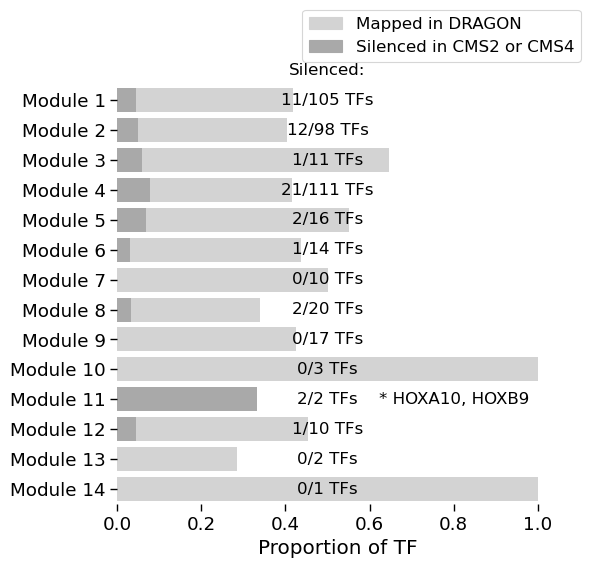

In [319]:
from matplotlib.patches import Patch
f, ax = plt.subplots(figsize=(6, 6))
lightgray = '#D3D3D3'
darkdarkgray = '#A9A9A9'
sns.barplot(y='module', x='mapped_in_dragon', data=all, color = lightgray, orient='h', ax = ax)
sns.barplot(y='module', x='lower_of_all', data=all, color = darkdarkgray, orient='h', ax = ax)
# create a legend with the two colors (lightblue and salmon), I need the colors
legend_elements = [Patch(facecolor=lightgray, edgecolor=lightgray, label='Mapped in DRAGON'),
                   Patch(facecolor=darkdarkgray, edgecolor=darkdarkgray, label='Silenced in CMS2 or CMS4')]
plt.legend(handles=legend_elements, loc='upper left', frameon=True, bbox_to_anchor=(0.4, 1.2), fontsize=12)
plt.ylabel('')
plt.xlabel('Proportion of TF')

ax.set_yticklabels([f'Module {i+1}' for i in ax.get_yticks()])

plt.text(0.5, -1 , 'Silenced:', fontsize=12, va='center', ha='center', color='Black', rotation=0)

for i in range(len(all)):
    module = all.iloc[i]['module']
    n_tfs = all.iloc[i]['total_tf']
    if n_tfs>0:
        annot = all.iloc[i]['numbers']
        annot = annot.split('(')[0] + 'TFs'
        plt.text(0.5, i ,annot , fontsize=12, va='center', ha='center', color='Black', rotation=0)
        if module == 11:
            plt.text(0.8, i , '* HOXA10, HOXB9', fontsize=12, va='center', ha='center', color='Black', rotation=0)



# Despine
sns.despine(left=True, bottom=True)

plt.tight_layout()


plt.show()  


In [230]:
all['numbers'] = all['node1_tf_lower'].fillna(0).astype(int).astype(str) + '/' + all['total_tf'].astype(int).astype(str) + ' (' + all['percentage_lower'].fillna(0).round(2).astype(str) + '%)'
number_tf_map = all.set_index('module')['numbers'].to_dict()

<Axes: xlabel='module', ylabel='dragon'>

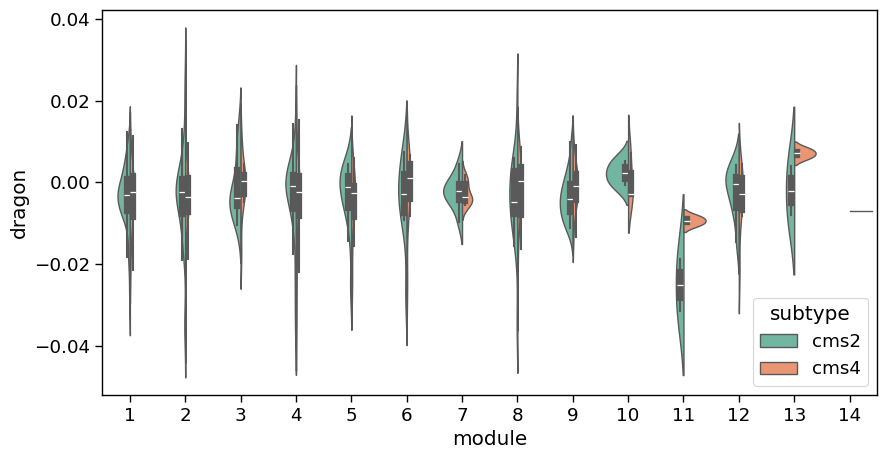

In [231]:
ttt4 = membership_dragon.loc[:,['module','cms4','raw_modularity']]
ttt4['subtype'] = 'cms4'
ttt4 = ttt4.rename(columns={'cms4': 'dragon'})

ttt2 = membership_dragon.loc[:,['module','cms2','raw_modularity']]
ttt2['subtype'] = 'cms2'
ttt2 = ttt2.rename(columns={'cms2': 'dragon'})

ttt = pd.concat([ttt2, ttt4], axis=0)
f, ax = plt.subplots(figsize=(10,5))
sns.violinplot(x = 'module', y = 'dragon', data = ttt.reset_index(), palette = 'Set2', hue= 'subtype', split=True)


In [232]:
membership_dragon['cms2-cms4'] = membership_dragon['cms2'] - membership_dragon['cms4']
membership_dragon['lower_cms2_cms4'] = 2*membership_dragon['cms2_lower']+1*membership_dragon['cms4_lower']
membership_dragon['lower_cms2_cms4']  = membership_dragon['lower_cms2_cms4'].map({0:'none', 1:'cms4', 2:'cms2', 3:'both'})

In [234]:
l2 = membership_dragon[membership_dragon['lower']>0].loc[:,['module','node1_tf','cms2','cms2_lower','lower_cms2_cms4']].reset_index()
l2.columns = ['index', 'module', 'node1_tf', 'DRAGON M-E', 'islower', 'lower_cms2_cms4']
l2['subtype'] = 'cms2'

l4 = membership_dragon[membership_dragon['lower']>0].loc[:,['module','node1_tf','cms4','cms4_lower','lower_cms2_cms4']].reset_index()
l4.columns = ['index', 'module', 'node1_tf', 'DRAGON M-E', 'islower', 'lower_cms2_cms4']
l4['subtype'] = 'cms4'

lll = pd.concat([l2, l4], axis=0)
lll

index  module node1_tf  DRAGON M-E  islower lower_cms2_cms4 subtype
0      10       2     BATF   -0.033872     True            both    cms2
1      24       5  CENPBD1   -0.025666     True            both    cms2
2      27       6  CREB3L1   -0.027208     True            both    cms2
3      32       5    CXXC5   -0.014416    False            cms4    cms2
4      68       1    FOXC2         NaN    False            cms4    cms2
..    ...     ...      ...         ...      ...             ...     ...
48    390       4   ZNF605   -0.019966     True            cms4    cms4
49    399       4   ZNF704   -0.013453    False            cms2    cms4
50    408       4   ZNF785   -0.021827     True            both    cms4
51    410       1     ZNF8   -0.010338    False            cms2    cms4
52    416       4   ZNF880   -0.026928     True            both    cms4

[106 rows x 7 columns]

In [648]:
number_tf_map

{1: 105,
 2: 98,
 3: 11,
 4: 111,
 5: 16,
 6: 14,
 7: 10,
 8: 20,
 9: 17,
 10: 3,
 11: 2,
 12: 10,
 13: 2,
 14: 1}

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/968387945.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll.reset_index(), hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)


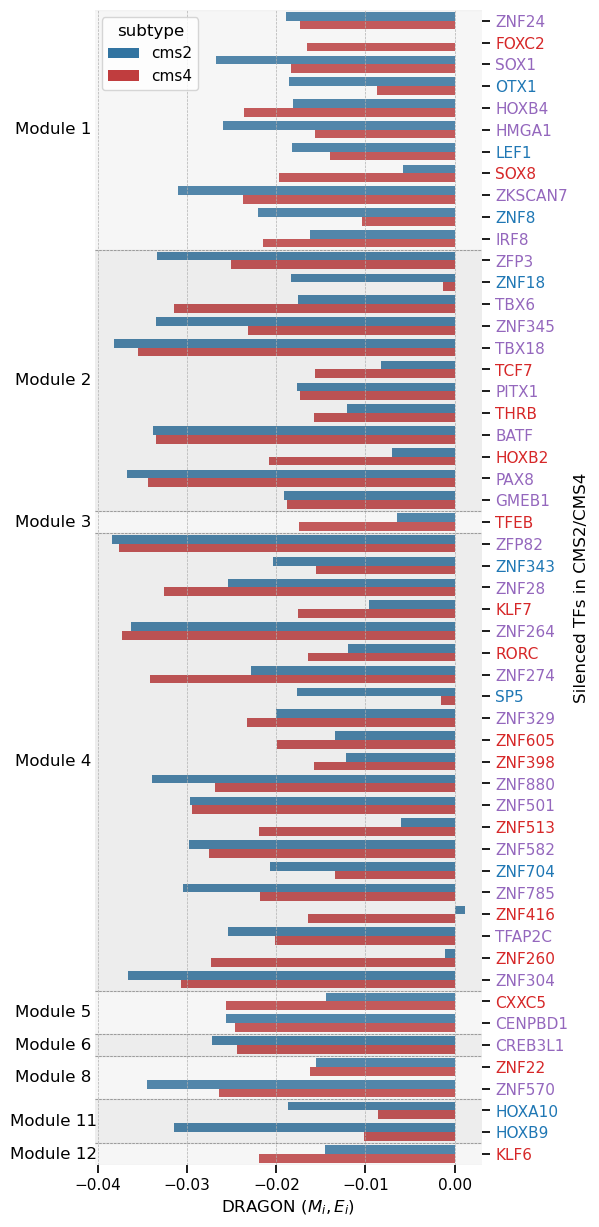

In [650]:
lll = lll.sort_values('module')
f, ax = plt.subplots(figsize=(5,15))
pal = sns.color_palette(['#808080', '#1f77b4', '#d62728', '#9467bd'])

ax.grid(axis = 'x', linestyle='--', linewidth=0.5)

sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll.reset_index(), hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)
# add horizontal lines for each module, you need to count how many TFs are in each module, because they need to separate
# the bars
total = 0
for i, module in enumerate(lll['module'].unique()):
    n_tfs = len(lll[lll['module']==module])/2
    total = total + n_tfs
    plt.axhline(y=total-0.5, color='gray', linestyle='--', linewidth=0.5)
    # chose a dark gray color for the module label
    plt.text(-0.045, total-n_tfs/2-0.5, f'Module {module}', fontsize=12, va='center', ha='center', color='Black', rotation = 0)

# Can you swap the ytick labels to be on the right side of the plot?
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
        
# Color the yticklabels based on lower_cms2_cms4
for i, label in enumerate(ax.get_yticklabels()):
    a = lll[lll['node1_tf'] == label.get_text()]['lower_cms2_cms4']
    if a.iloc[0] == 'cms2':
        label.set_color('#1f77b4')
    elif a.iloc[0] == 'cms4':
        label.set_color('#d62728')
    elif a.iloc[0] == 'both':
        label.set_color('#9467bd')
    else:
        label.set_color('gray')

# Despine the axes
sns.despine(ax=ax, left=True, bottom=True)

# Can you color the module background alternating dark and light gray?
total = 0
for i, module in enumerate(lll['module'].unique()):
    n_tfs = len(lll[lll['module']==module])/2
    total = total + n_tfs
    if i % 2 == 0:
        ax.add_patch(plt.Rectangle((-0.05, total-n_tfs-0.5), 1.05, n_tfs, color='lightgray', alpha=0.2))
    else:
        ax.add_patch(plt.Rectangle((-0.05, total-n_tfs-0.5), 1.05, n_tfs, color='darkgray', alpha=0.2))

ax.set_ylabel('Silenced TFs in CMS2/CMS4')
ax.set_xlabel('DRAGON ($M_i,E_i)$')
f.savefig(outputDir + 'dragon_tf_silenced.pdf', dpi=300, bbox_inches='tight')

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/134254546.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll11, hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)


Text(0.5, 0, 'DRAGON ($M_i,E_i)$')

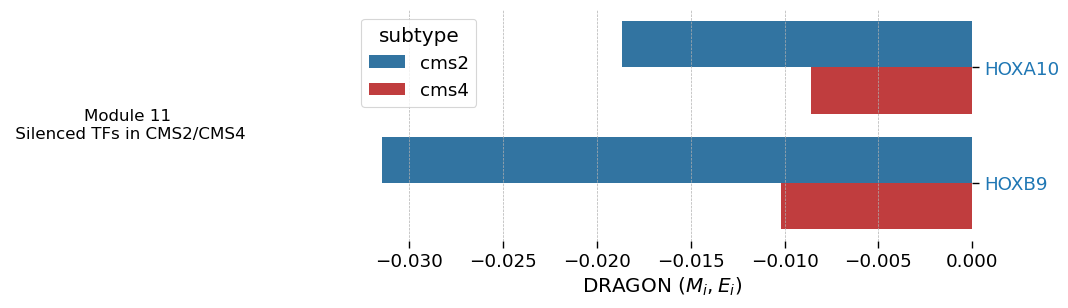

In [312]:
lll = lll.sort_values('module')
lll11 = lll[lll['module']==11].reset_index()
f, ax = plt.subplots(figsize=(8,3))
pal = sns.color_palette(['#808080', '#1f77b4', '#d62728', '#9467bd'])

ax.grid(axis = 'x', linestyle='--', linewidth=0.5)

sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll11, hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)
# add horizontal lines for each module, you need to count how many TFs are in each module, because they need to separate
# the bars
total = 0
for i, module in enumerate(lll11['module'].unique()):
    n_tfs = len(lll11[lll11['module']==module])/2
    total = total + n_tfs
    # chose a dark gray color for the module label
    plt.text(-0.045, total-n_tfs/2-0.5, f'Module {module}\n Silenced TFs in CMS2/CMS4', fontsize=12, va='center', ha='center', color='Black', rotation = 0)

# Can you swap the ytick labels to be on the right side of the plot?
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
        
# Color the yticklabels based on lower_cms2_cms4
for i, label in enumerate(ax.get_yticklabels()):
    a = lll[lll['node1_tf'] == label.get_text()]['lower_cms2_cms4']
    if a.iloc[0] == 'cms2':
        label.set_color('#1f77b4')
    elif a.iloc[0] == 'cms4':
        label.set_color('#d62728')
    elif a.iloc[0] == 'both':
        label.set_color('#9467bd')
    else:
        label.set_color('gray')

# Despine the axes
sns.despine(ax=ax, left=True, bottom=True)

ax.set_ylabel('')
ax.set_xlabel('DRAGON ($M_i,E_i)$')

In [82]:
membership_dragon[membership_dragon['module']==11]

node  module  modularity node_name node_type  n_tf  raw_modularity  \
101  HOXA10_A      11    0.187273    HOXA10         A     6        1.123641   
112   HOXB9_A      11    0.188562     HOXB9         A     6        1.131375   

                  node1              node2      cms1  ...  node2_type  \
101  HOXA10_methylation  HOXA10_expression -0.011322  ...  expression   
112   HOXB9_methylation   HOXB9_expression -0.004940  ...  expression   

     node1_tf  node2_tf  cms2_abs  cms4_abs  same same TF cms2_lower  \
101    HOXA10    HOXA10  0.018662  0.008572     1    True       True   
112     HOXB9     HOXB9  0.031465  0.010178     1    True       True   

    cms4_lower lower  
101      False     1  
112      False     1  

[2 rows x 27 columns]

## Alpaca module 11

In [254]:
module11 = membership[membership['module']==11].sort_values('modularity', ascending=False)
module11_tf = module11[module11['node_type']=='A']['node_name'].values.tolist()
module11_gene = module11[module11['node_type']=='B']['node_name'].values.tolist()


In [324]:
panda_cms2_module11 = cms2_net.loc[module11_tf, module11_gene]

In [325]:
panda_cms4_module11 = cms4_net.loc[module11_tf, module11_gene]

In [336]:
panda_cms2_module11.melt(ignore_index=False)

variable     value
tf                               
HOXC9   ENSG00000265618  7.233137
HOXB9   ENSG00000265618  6.902970
HOXA11  ENSG00000265618  7.959242
HOXA10  ENSG00000265618  6.703803
HOXD11  ENSG00000265618  7.009923
...                 ...       ...
HOXB9   ENSG00000217576  0.647471
HOXA11  ENSG00000217576  0.438937
HOXA10  ENSG00000217576  0.653638
HOXD11  ENSG00000217576  0.660190
KDM2B   ENSG00000217576  0.200492

[624 rows x 2 columns]

In [342]:
mod11_pandas = pd.DataFrame({'cms2': panda_cms2_module11.values.flatten(), 'cms4': panda_cms4_module11.values.flatten()})
mod11_pandas['cms2-cms4'] = mod11_pandas['cms2'] - mod11_pandas['cms4']
# add column of the edges using index and columns
temp_melt = panda_cms2_module11.melt(ignore_index=False)
mod11_pandas['edge'] = [temp_melt.index[i] + '-' + temp_melt['variable'].values[i] for i in range(len(temp_melt))]
mod11_pandas.sort_values('cms2-cms4')

cms2      cms4  cms2-cms4                    edge
318  5.621876  6.264485  -0.642609   HOXC9-ENSG00000137962
356  3.518976  4.154828  -0.635852  HOXA11-ENSG00000138399
148  3.666368  4.298719  -0.632351  HOXD11-ENSG00000226784
110  5.778447  6.392921  -0.614474  HOXA11-ENSG00000138780
422  5.945970  6.555453  -0.609482  HOXA11-ENSG00000109458
..        ...       ...        ...                     ...
406  6.021917  4.937931   1.083986  HOXD11-ENSG00000148935
396  5.035043  3.930935   1.104108   HOXC9-ENSG00000087470
500  5.396102  4.270233   1.125869  HOXA11-ENSG00000271730
198  6.094882  4.928330   1.166552   HOXC9-ENSG00000253102
188  5.228856  4.035667   1.193189  HOXA11-ENSG00000150768

[624 rows x 4 columns]

<Axes: >

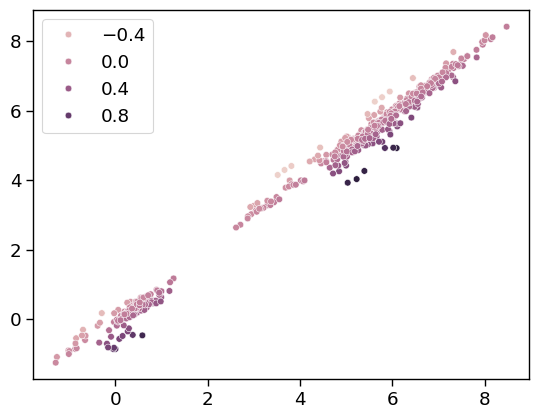

In [327]:
sns.scatterplot(x = panda_cms2_module11.values.flatten(), y = panda_cms4_module11.values.flatten(), hue = panda_cms2_module11.values.flatten() - panda_cms4_module11.values.flatten())

## Cluster A and D from DRAGON

In [6]:
dragon_clusters = pd.read_csv('/Users/violafanfani/Documents/uni-harvard/projects/tcga-data-supplement/results/cms-post/top_dragon_edges.csv', index_col=0)
dragon_clusters

cms1      cms2      cms3      cms4  cluster_number cluster
edge                                                                          
ZNF345-ZNF790  -0.012222 -0.028967 -0.009026 -0.026827               3       C
HOXB5-HOXB6    -0.006764 -0.020931 -0.013662 -0.022181               2       B
HOXB8-HOXB6    -0.013081 -0.021357 -0.010234 -0.017450               2       B
HOXB8-HOXB5    -0.013158 -0.021508 -0.009058 -0.018268               2       B
HOXB5-HOXB4    -0.008069 -0.022063 -0.012032 -0.019201               2       B
...                  ...       ...       ...       ...             ...     ...
STAT5A-PPARG    0.000949 -0.014860 -0.007660 -0.013302               2       B
ZNF280D-ZNF513 -0.003187 -0.008399 -0.007266  0.017902               4       D
DOT1L-EVX1      0.004228 -0.010934  0.006868 -0.014698               2       B
MYOG-NFE2L3     0.004753 -0.011374 -0.008851  0.011738               4       D
THAP3-ZNF513   -0.001000 -0.012193 -0.005502 -0.018000               2       B

[200 rows x 6 columns]

In [9]:
# We retrieve the clusters
clusts = {}
for i,tab in dragon_clusters.groupby('cluster'):
    print(i, len(tab))
    meth = [i.split('-')[0] for i in tab.index]
    expr = [i.split('-')[1] for i in tab.index]
    all = meth+expr
    clusts[i] = {}
    clusts[i]['all'] = all
    clusts[i]['meth'] = meth
    clusts[i]['expr'] = expr

A 21
B 82
C 1
D 23
E 73


In [11]:
dragon_clusters

cms1      cms2      cms3      cms4  cluster_number cluster
edge                                                                          
ZNF345-ZNF790  -0.012222 -0.028967 -0.009026 -0.026827               3       C
HOXB5-HOXB6    -0.006764 -0.020931 -0.013662 -0.022181               2       B
HOXB8-HOXB6    -0.013081 -0.021357 -0.010234 -0.017450               2       B
HOXB8-HOXB5    -0.013158 -0.021508 -0.009058 -0.018268               2       B
HOXB5-HOXB4    -0.008069 -0.022063 -0.012032 -0.019201               2       B
...                  ...       ...       ...       ...             ...     ...
STAT5A-PPARG    0.000949 -0.014860 -0.007660 -0.013302               2       B
ZNF280D-ZNF513 -0.003187 -0.008399 -0.007266  0.017902               4       D
DOT1L-EVX1      0.004228 -0.010934  0.006868 -0.014698               2       B
MYOG-NFE2L3     0.004753 -0.011374 -0.008851  0.011738               4       D
THAP3-ZNF513   -0.001000 -0.012193 -0.005502 -0.018000               2       B

[200 rows x 6 columns]

In [13]:
# split the edge into node1 and node2
dragon_clusters['node1'] = [i.split('-')[0] for i in dragon_clusters.index]
dragon_clusters['node2'] = [i.split('-')[1] for i in dragon_clusters.index]
dragon_clusters.head()

cms1      cms2      cms3      cms4  cluster_number cluster  \
edge                                                                            
ZNF345-ZNF790 -0.012222 -0.028967 -0.009026 -0.026827               3       C   
HOXB5-HOXB6   -0.006764 -0.020931 -0.013662 -0.022181               2       B   
HOXB8-HOXB6   -0.013081 -0.021357 -0.010234 -0.017450               2       B   
HOXB8-HOXB5   -0.013158 -0.021508 -0.009058 -0.018268               2       B   
HOXB5-HOXB4   -0.008069 -0.022063 -0.012032 -0.019201               2       B   

                node1   node2  
edge                           
ZNF345-ZNF790  ZNF345  ZNF790  
HOXB5-HOXB6     HOXB5   HOXB6  
HOXB8-HOXB6     HOXB8   HOXB6  
HOXB8-HOXB5     HOXB8   HOXB5  
HOXB5-HOXB4     HOXB5   HOXB4

In [18]:
membership_clusters = (membership.merge(dragon_clusters.loc[:,['cluster','node1','node2']], left_on='node_name', right_on='node1', how='left')).merge(dragon_clusters.loc[:,['cluster','node1','node2']], left_on='node_name', right_on='node2', how='left', suffixes=('_m', '_e'))
membership_clusters.head()

node  module  modularity node_name node_type cluster_m node1_m node2_m  \
0   ALX1_A       1    0.006097      ALX1         A       NaN     NaN     NaN   
1   ALX3_A       2    0.011064      ALX3         A       NaN     NaN     NaN   
2   ALX4_A       1    0.005248      ALX4         A       NaN     NaN     NaN   
3     AR_A       2    0.001445        AR         A       NaN     NaN     NaN   
4  ARGFX_A       2    0.012254     ARGFX         A       NaN     NaN     NaN   

  cluster_e node1_e node2_e  
0       NaN     NaN     NaN  
1       NaN     NaN     NaN  
2       NaN     NaN     NaN  
3       NaN     NaN     NaN  
4       NaN     NaN     NaN

In [19]:
membership_clusters.dropna(subset=['cluster_m', 'cluster_e'])

node  module  modularity node_name node_type cluster_m node1_m  \
20    ATOH1_A       2    0.003593     ATOH1         A         E   ATOH1   
26    BARX2_A       1    0.006082     BARX2         A         E   BARX2   
27     BATF_A       2    0.001361      BATF         A         B    BATF   
28     BATF_A       2    0.001361      BATF         A         B    BATF   
29     BATF_A       2    0.001361      BATF         A         B    BATF   
..        ...     ...         ...       ...       ...       ...     ...   
986  ZNF570_A       8    0.030109    ZNF570         A         B  ZNF570   
987  ZNF570_A       8    0.030109    ZNF570         A         B  ZNF570   
988  ZNF570_A       8    0.030109    ZNF570         A         B  ZNF570   
989  ZNF570_A       8    0.030109    ZNF570         A         B  ZNF570   
990  ZNF570_A       8    0.030109    ZNF570         A         B  ZNF570   

    node2_m cluster_e node1_e node2_e  
20     IRF4         E   PROP1   ATOH1  
26     IRF4         B  TFAP2A   BARX2  
27     ZFP3         D   ATOH7    BATF  
28     ZFP3         B   NAIF1    BATF  
29   ZNF860         D   ATOH7    BATF  
..      ...       ...     ...     ...  
986  ZNF790         B  ZNF790  ZNF570  
987  ZNF347         B  ZNF345  ZNF570  
988  ZNF347         B  ZNF461  ZNF570  
989  ZNF347         B   ZNF14  ZNF570  
990  ZNF347         B  ZNF790  ZNF570  

[71 rows x 11 columns]

<Axes: xlabel='module', ylabel='count'>

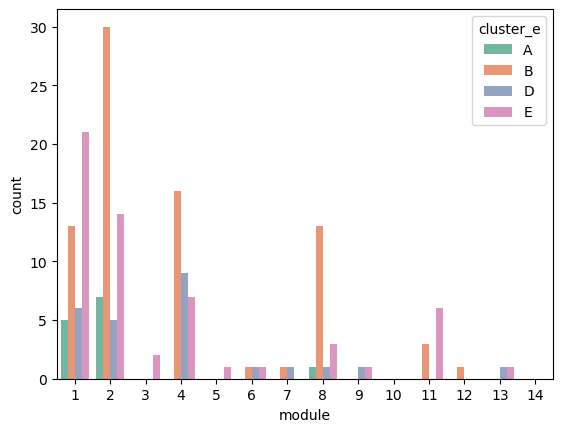

In [29]:
sns.countplot(x='module', data=membership_clusters, hue='cluster_e', palette='Set2', hue_order = ['A','B','D','E'], order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

<Axes: xlabel='module', ylabel='count'>

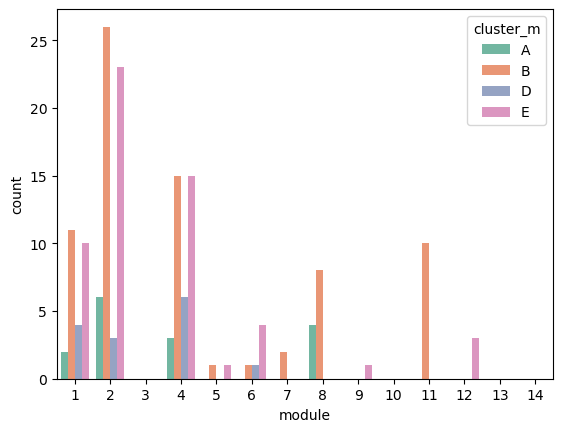

In [28]:
sns.countplot(x='module', data=membership_clusters, hue='cluster_m', palette='Set2', hue_order = ['A','B','D','E'], order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

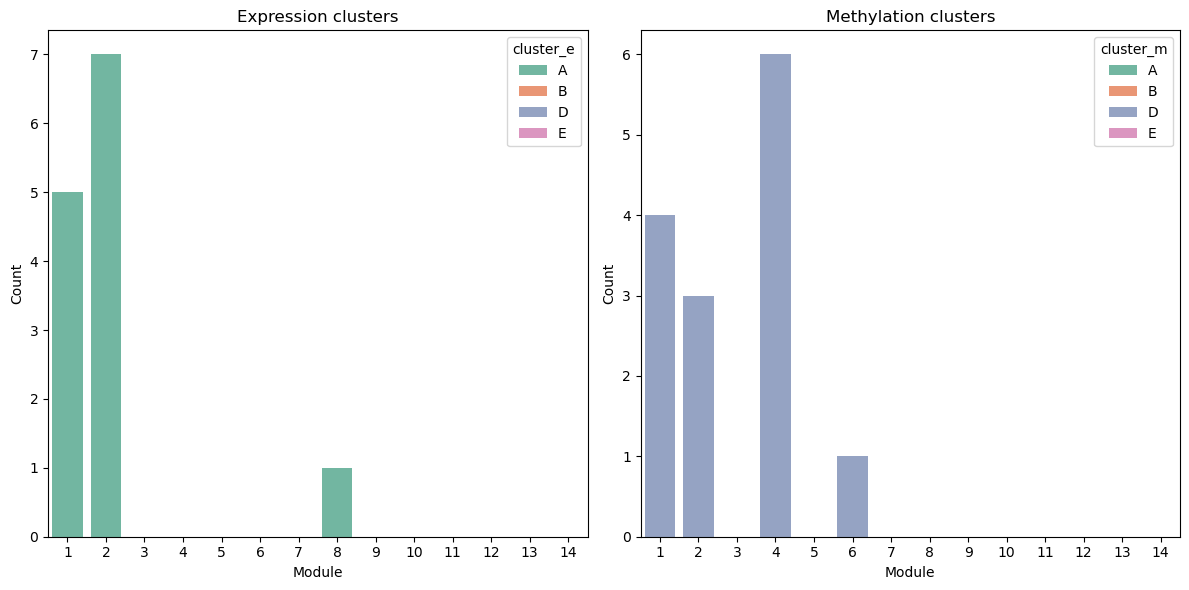

In [30]:
# do the same as above only for A and D clusters, do a subplot with two columns, one for A and one for D
f, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='module', data=membership_clusters[membership_clusters['cluster_e']=='A'], hue='cluster_e', palette='Set2', hue_order = ['A','B','D','E'], order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14], ax=ax[0])
ax[0].set_title('Expression clusters')
sns.countplot(x='module', data=membership_clusters[membership_clusters['cluster_m']=='D'], hue='cluster_m', palette='Set2', hue_order = ['A','B','D','E'], order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14], ax=ax[1])
ax[1].set_title('Methylation clusters')
ax[0].set_xlabel('Module')
ax[1].set_xlabel('Module')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.tight_layout()

In [33]:
df_all = pd.DataFrame(columns=['node_name', 'cluster'])
for k, v in clusts.items():
    print(k, len(v['all']))
    temp = pd.DataFrame({'node_name': v['all'], 'cluster': k})
    df_all = pd.concat([df_all, temp], axis=0)

dragon_membership = df_all.merge(membership, on='node_name', how='left')
dragon_membership.head()


A 42
B 164
C 2
D 46
E 146


node_name cluster      node  module  modularity node_type
0    ZNF274       A  ZNF274_A     4.0    0.000870         A
1      EVX1       A    EVX1_A     2.0    0.003931         A
2    NFE2L3       A  NFE2L3_A     1.0    0.001115         A
3     HOXA3       A   HOXA3_A     2.0    0.006618         A
4     MEOX2       A   MEOX2_A     2.0    0.009438         A

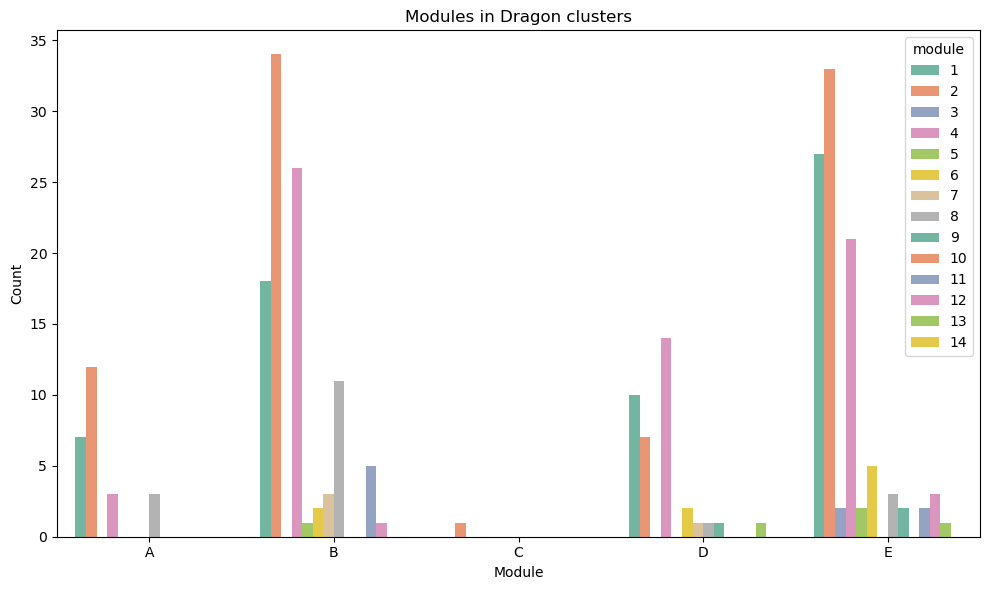

In [36]:
# countplot of the modules in the clusters
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='cluster', data=dragon_membership, hue='module', palette='Set2', order = ['A','B','C','D','E'], hue_order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_title('Modules in Dragon clusters')
ax.set_xlabel('Module')
ax.set_ylabel('Count')
plt.tight_layout()

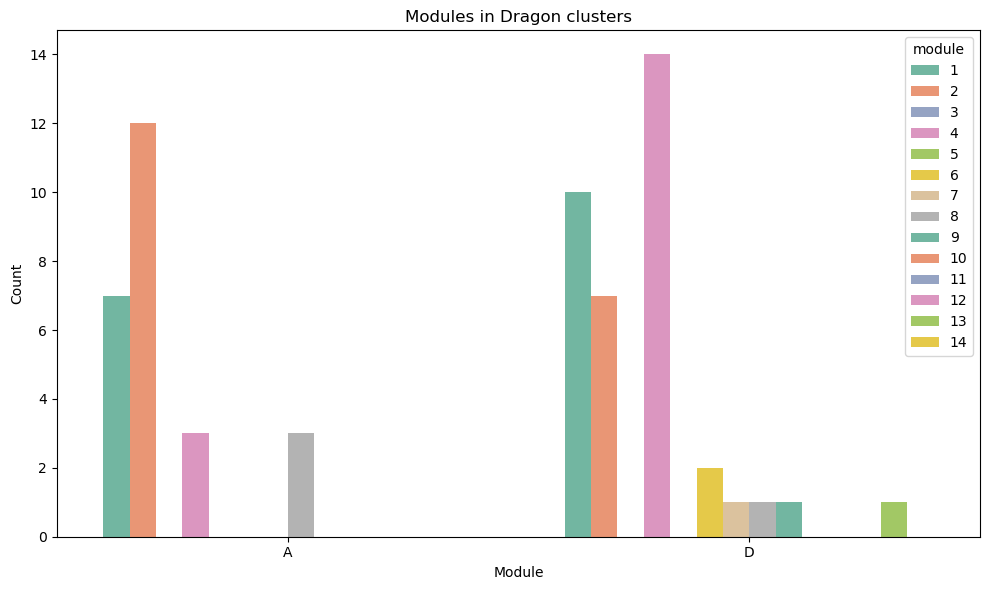

In [37]:
# countplot of the modules in the clusters
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='cluster', data=dragon_membership, hue='module', palette='Set2', order = ['A','D'], hue_order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_title('Modules in Dragon clusters')
ax.set_xlabel('Module')
ax.set_ylabel('Count')
plt.tight_layout()